# Comparing the different Polymath projects

We start by setting up, loading the urls of the discussions, and putting everything in a frame.

In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
import json
import pandas as pd
from pandas import DataFrame
from urllib.parse import urlparse

from comment_thread import *
from author_network import *

In [2]:
def process_polymath(project, split=False):
    message = "Polymath {}".format(project[-1]) if project.startswith("pm") else "Mini Polymath {}".format(project[-1])
    SETTINGS = {
    'msg' : message,
    'filename' : message.replace(" ", ""),
    'source' : project,
    'urls' : [],
    'type' : '',
    'parser' : 'html5lib',
    'cmap' : plt.cm.Paired, # not a string, this is an object
    'vmin' : 1,
    'vmax' : 100}
    
    with open("DATA/"+ SETTINGS['source'] + ".txt", "r") as input:
        soup = BeautifulSoup(input.readline(), "html.parser")
    
    #items = soup.find("ul").find_all("li")
    urls, titles = zip(*[(item.get("href"), item.text) for item in soup.find_all("a")])
    
    if project == "pm1":
        research = [title.startswith(" (") for title in titles]
    else:
        research = ["discussion" not in title.lower() for title in titles]
        
    pm_frame = DataFrame({
        'url': urls,
        'title' : titles,
        'blog' : [urlparse(url).netloc.split('.')[0].title() for url in urls],
        'research' : research},
        columns = ['title', 'url', 'blog', 'research'])
        
    pm_frame['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(pm_frame['url'], pm_frame['blog'])]
    pm_frame['number of comments'] = pm_frame['thread'].apply(lambda x: len(x.node_name.keys()))
    
    indices = pm_frame.index
    threads = pm_frame.thread
    pm_frame['mthread (single)'] = pm_frame['thread'].apply(MultiCommentThread)
    pm_frame['mthread (accumulated)'] = Series([MultiCommentThread(*threads[0:i+1]) for i in indices],
                                               index=indices)
    pm_frame['network'] = pm_frame['mthread (accumulated)'].apply(AuthorNetwork)
    
    if split and not pm_frame['research'].all():
        r_indices = pm_frame[pm_frame['research']].index
        d_indices = pm_frame[~pm_frame['research']].index
        r_threads = pm_frame[pm_frame['research']].thread
        d_threads = pm_frame[~pm_frame['research']].thread
        pm_frame['r_mthread (accumulated)'] = Series([MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                                 index=r_indices)
        pm_frame['d_mthread (accumulated)'] = Series([MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                                                 index=d_indices)
        pm_frame['r_network'] = pm_frame[pm_frame['research']]['r_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame['d_network'] = pm_frame[~pm_frame['research']]['d_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                                      'thread', 'mthread (single)',
                                      'mthread (accumulated)', 'network',
                                      'r_mthread (accumulated)', 'r_network',
                                      'd_mthread (accumulated)', 'd_network'],
                                     axis=1)
    else:
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                                      'thread', 'mthread (single)',
                                      'mthread (accumulated)', 'network'],
                                     axis=1)

    pm_frame.index = pd.MultiIndex.from_tuples([(SETTINGS['msg'], i) for i in indices],
                                               names=['Project', 'Ord'])
    
    return pm_frame

In [3]:
PM1_FRAME = process_polymath("pm1", split=True)

In [4]:
PM2_FRAME = process_polymath("pm2", split=True)

In [5]:
mPM1_FRAME = process_polymath("mini_pm1", split=True)
mPM1_FRAME['title']=['Research Thread 1', 'Research Thread 2', 'Discussion Thread']
mPM1_FRAME['research']=["Discussion" not in title for title in mPM1_FRAME['title']]

In [6]:
PM3_FRAME = process_polymath("pm3", split=True)

In [7]:
PM4_FRAME = process_polymath("pm4", split=True)

In [8]:
PM5_FRAME = process_polymath("pm5", split=True)

In [9]:
mPM2_FRAME = process_polymath("mini_pm2", split=True)
mPM2_FRAME['research'] = [False, False, False, False, True]

In [10]:
PM6_FRAME = process_polymath("pm6", split=True)
PM6_FRAME['research'] = [True, False]

In [11]:
mPM3_FRAME = process_polymath("mini_pm3", split=True)
mPM3_FRAME['research'] = [False, False, True]

In [12]:
mPM4_FRAME = process_polymath("mini_pm4", split=True)
mPM4_FRAME['research'] = [False, False, False, True, True]

In [13]:
PM7_FRAME = process_polymath("pm7", split=True)

In [14]:
PM8_FRAME = process_polymath("pm8", split=True)

In [15]:
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME]
MINIPOLYMATHS = [mPM1_FRAME, mPM2_FRAME, mPM3_FRAME, mPM4_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]
mPM_FRAME = pd.concat(MINIPOLYMATHS)
PM_FRAME

title  \
Project    Ord                                                      
Polymath 1 0     Is massively collaborative mathematics possible?   
           1     A combinatorial approach to density Hales-Jewett   
           2    Upper and lower bounds for the density Hales-J...   
           3                        The triangle-removal approach   
           4       Quasirandomness and obstructions to uniformity   
           5                            Possible proof strategies   
           6            A reading seminar on density Hales-Jewett   
           7    Bounds for the first few density Hales-Jewett ...   
           8                            Brief review of polymath1   
           9                                      DHJ(3): 851-899   
           10   DHJ(3): 900-999 (Density Hales-Jewett type num...   
           11                           Problem solved (probably)   
           12        Polymath1 and open collaborative mathematics   
           13               DHJ(3) and related results: 1050-1099   
           14   DHJ(3): 1100-1199 (Density Hales-Jewett type n...   
           15   An Open Discussion and Polls: Around Roth’s Th...   
           16   DHJ(k): 1200-1299 (Density Hales-Jewett type n...   
           17                       DHJ: writing the second paper   
           18                 DHJ: still writing the second paper   
           19                      DHJ write-up and other matters   
           20                  DHJ: writing the second paper III.   
           21     DHJ and Moser numbers: nearing the final draft.   
Polymath 2 0                                 Only Research Thread   
Polymath 3 0    The polynomial Hirsch conjecture, a proposal f...   
           1    The polynomial Hirsch conjecture, a proposal f...   
           2    The polynomial Hirsch conjecture - how to impr...   
           3    The Polynomial Hirsch Conjecture: Discussion T...   
           4    The Polynomial Hirsch Conjecture: Discussion T...   
           5                                  Plans for polymath3   
           6    The Polynomial Hirsch Conjecture: The Crux of ...   
...                                                           ...   
Polymath 8 7          Further analysis of the truncated GPY sieve   
           8            Estimation of the Type I and Type II sums   
           9                      Estimation of the Type III sums   
           10       A truncated elementary Selberg sieve of Pintz   
           11   Bounding short exponential sums on smooth modu...   
           12   The distribution of primes in densely divisibl...   
           13   Bounded gaps between primes (Polymath8) – a pr...   
           14              The quest for narrow admissible tuples   
           15   The distribution of primes in doubly densely d...   
           16                         An improved Type I estimate   
           17                        Polymath8: writing the paper   
           18                    Polymath8: writing the paper, II   
           19                   Polymath8: writing the paper, III   
           20                    Polymath8: writing the paper, IV   
           21   Polymath8: Writing the first paper, V, and a l...   
           22   Polymath8b: Bounded intervals with many primes...   
           23   Polymath8b, II: Optimising the variational pro...   
           24   Polymath8b, III: Numerical optimisation of the...   
           25   Polymath8b, IV: Enlarging the sieve support, m...   
           26   Polymath8b, V: Stretching the sieve support fu...   
           27   Polymath8b, VI: A low-dimensional variational ...   
           28   Polymath8b, VII: Using the generalised Elliott...   
           29   “New equidistribution estimates of Zhang type,...   
           30   Polymath8b, VIII: Time to start writing up the...   
           31            Polymath8b, IX: Large quadratic programs   
           32   Polymath8b, X: Writing the paper, and chas

In [16]:
def get_project(project, stage):
    return mPM_FRAME.loc[project].iloc[stage] if project.startswith("Mini") else PM_FRAME.loc[project].iloc[stage]

def draw_network(project, stage=-1):
    get_project(project, stage)['network'].draw_graph(project=project)

def plot_activity_pie(project, stage=-1):
    get_project(project, stage)['network'].plot_author_activity_pie(project=project)

def plot_degree_centrality(project, stage=-1):
    get_project(project, stage)['network'].plot_degree_centrality(project=project)

def plot_activity(project, max_span, activity='thread', stage=-1):
    get_project(project, stage)['mthread (accumulated)'].plot_activity(activity, intervals=1,
                                                                       max_span=max_span, project=project)

def plot_growth(project, drop_last=0, stage=-1):
    get_project(project, stage)['mthread (accumulated)'].plot_growth(drop_last=drop_last, project=project)
    
    


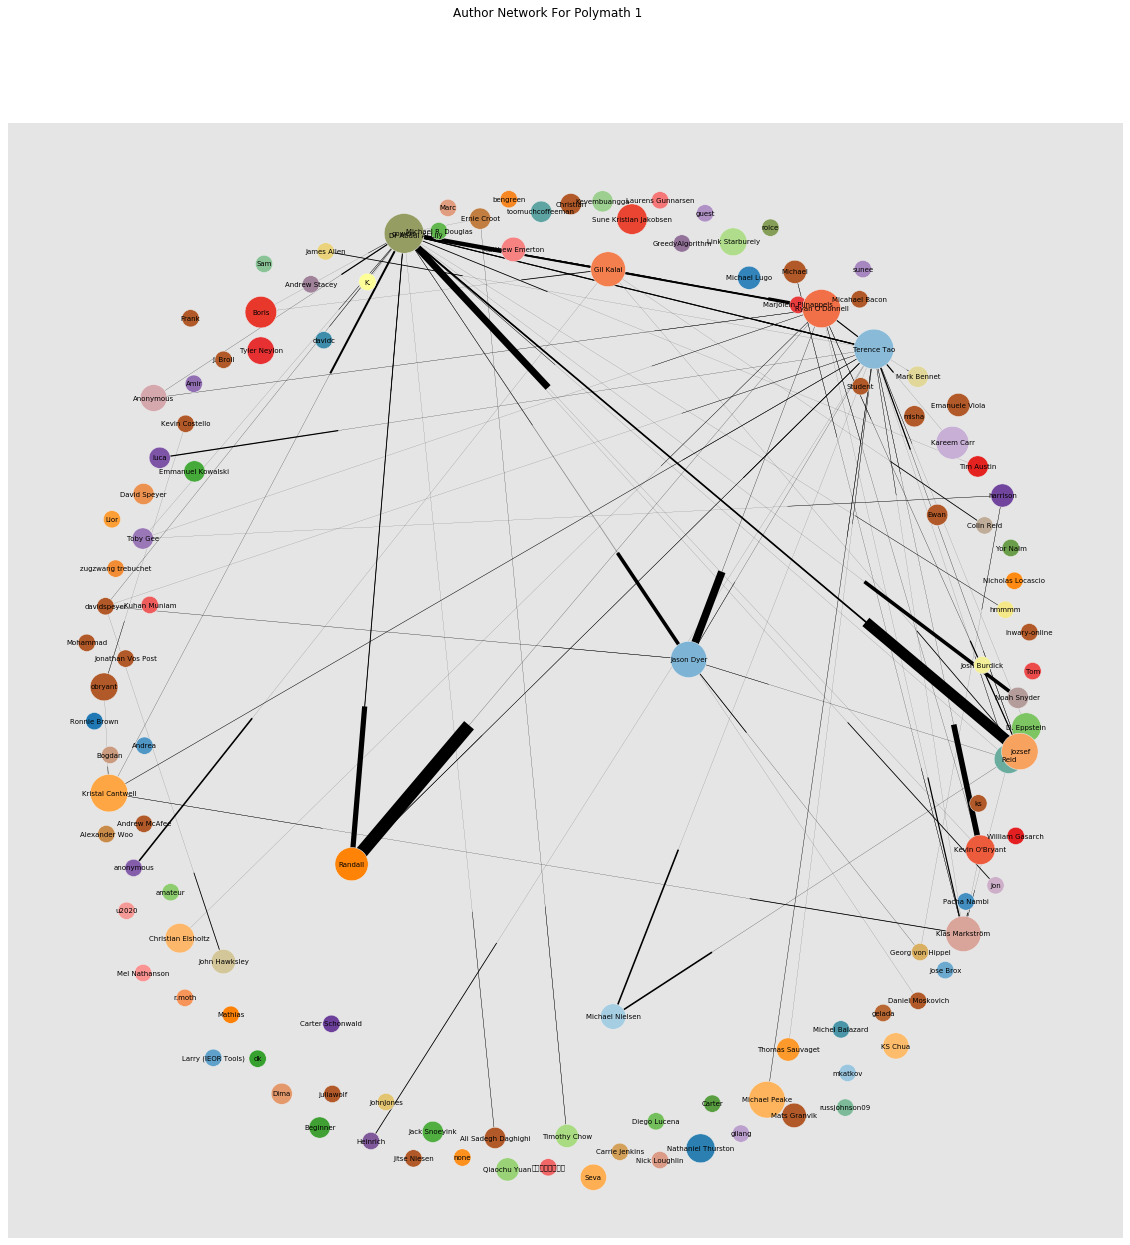

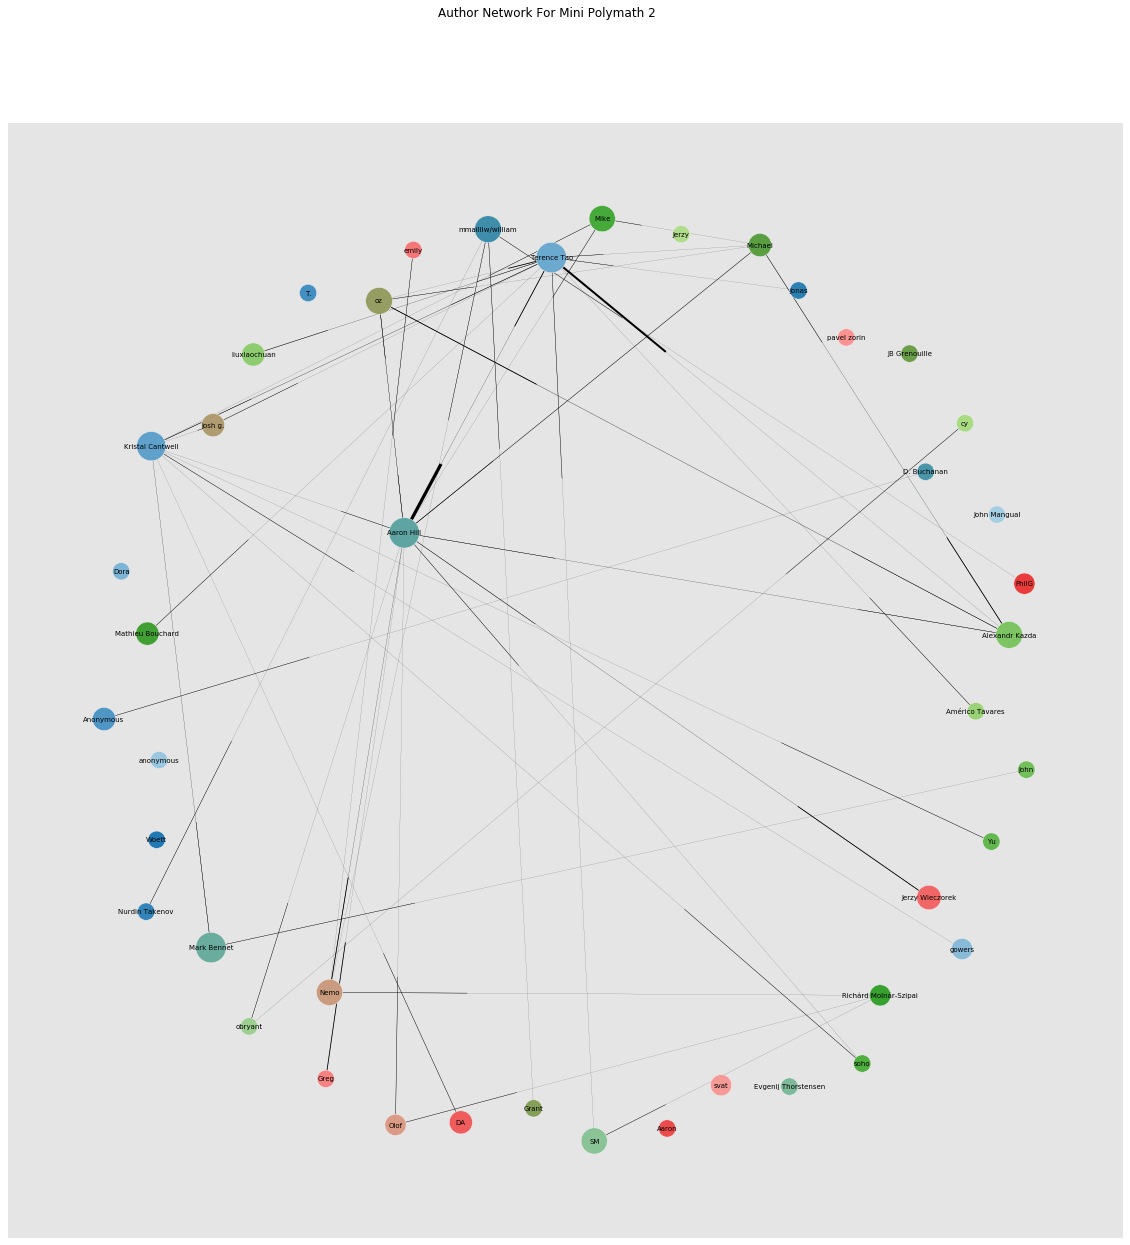

In [20]:
draw_network("Polymath 1")
draw_network("Mini Polymath 2")

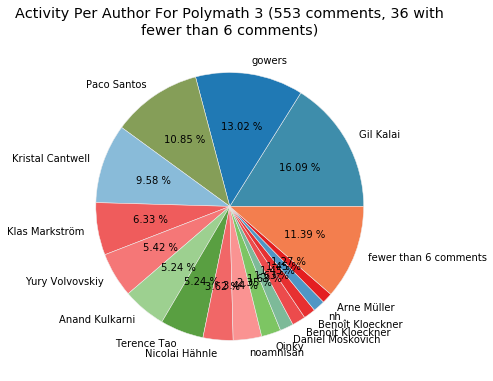

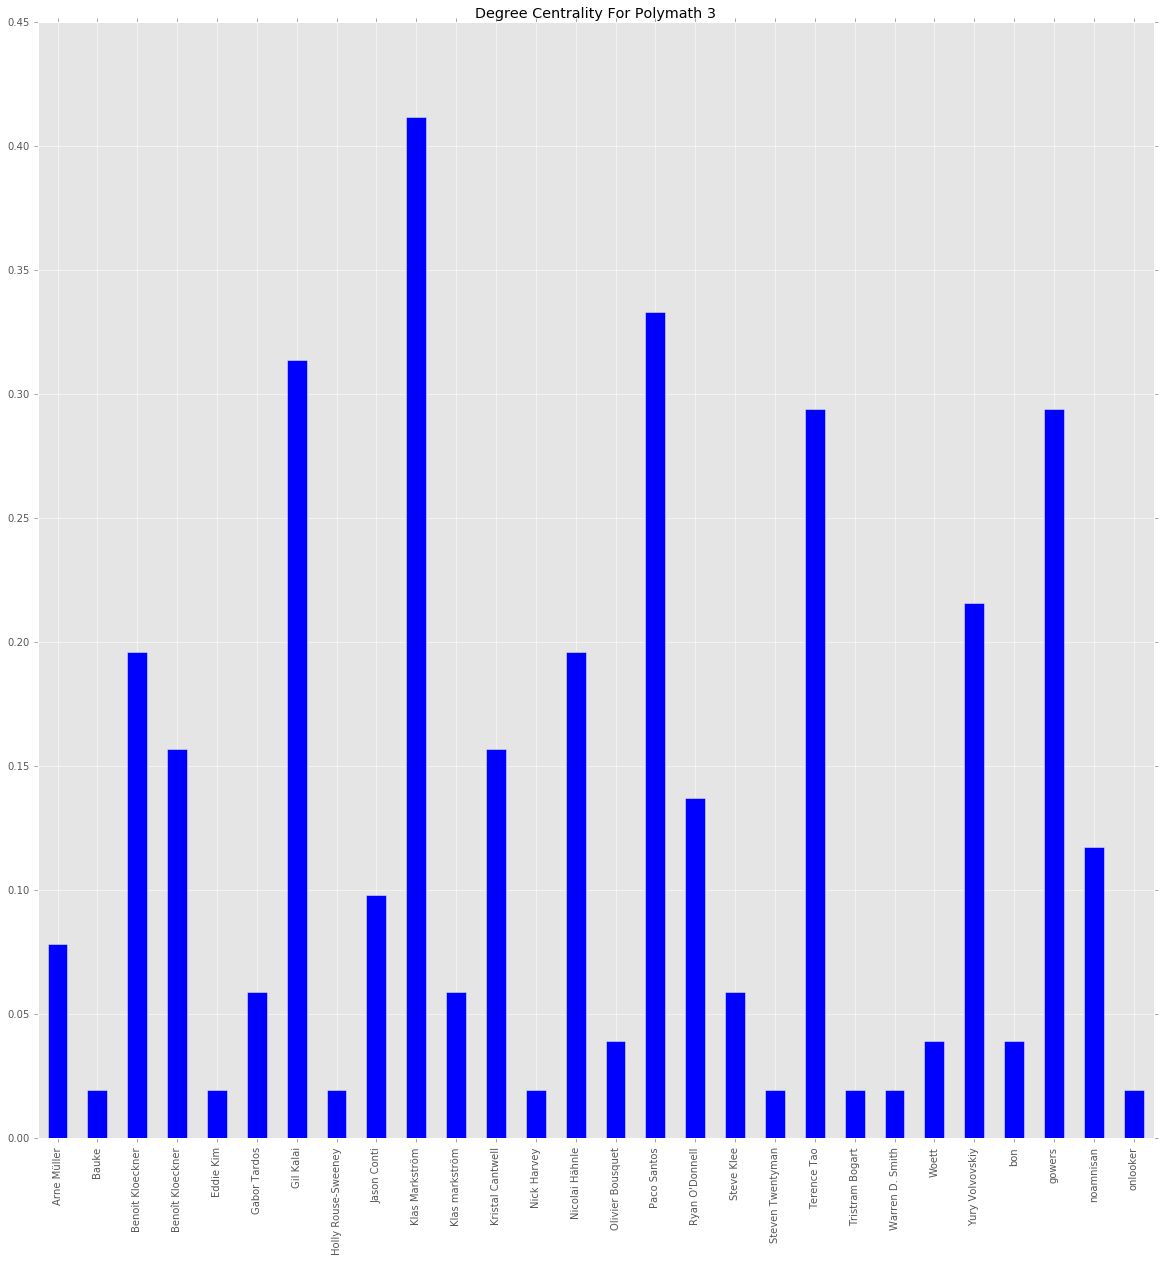

In [19]:
plot_activity_pie("Polymath 3")
plot_degree_centrality(project="Polymath 3")

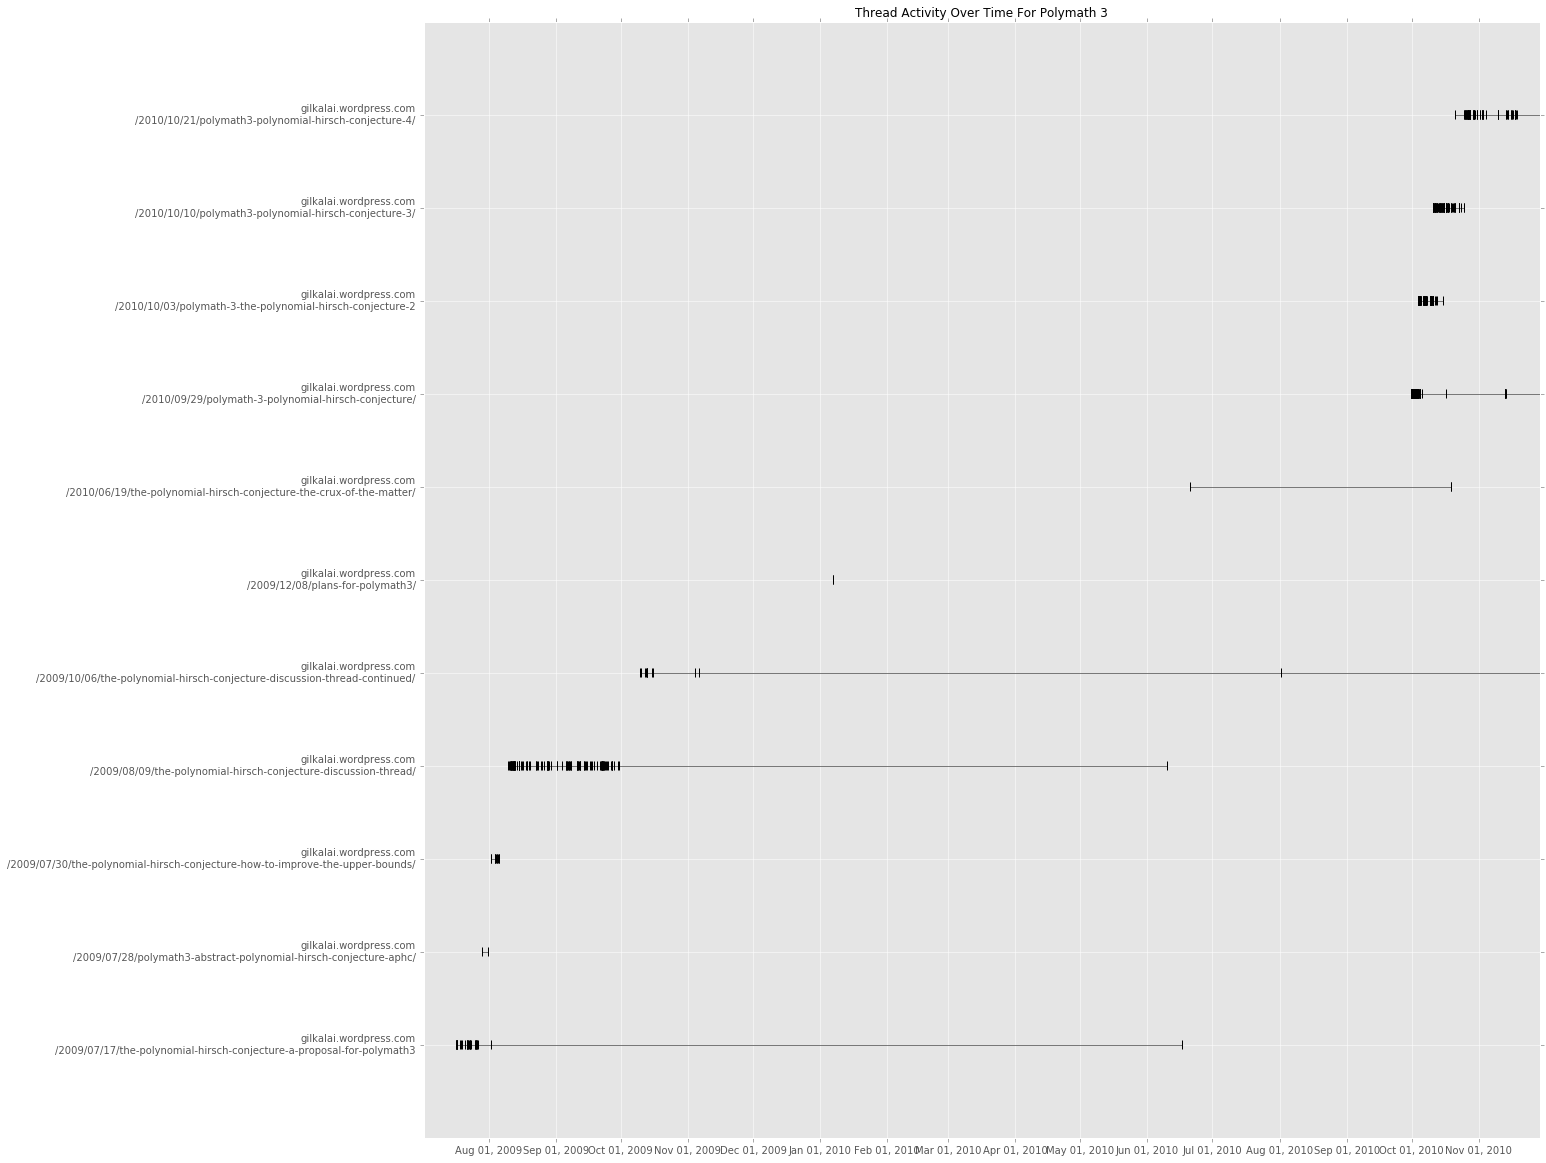

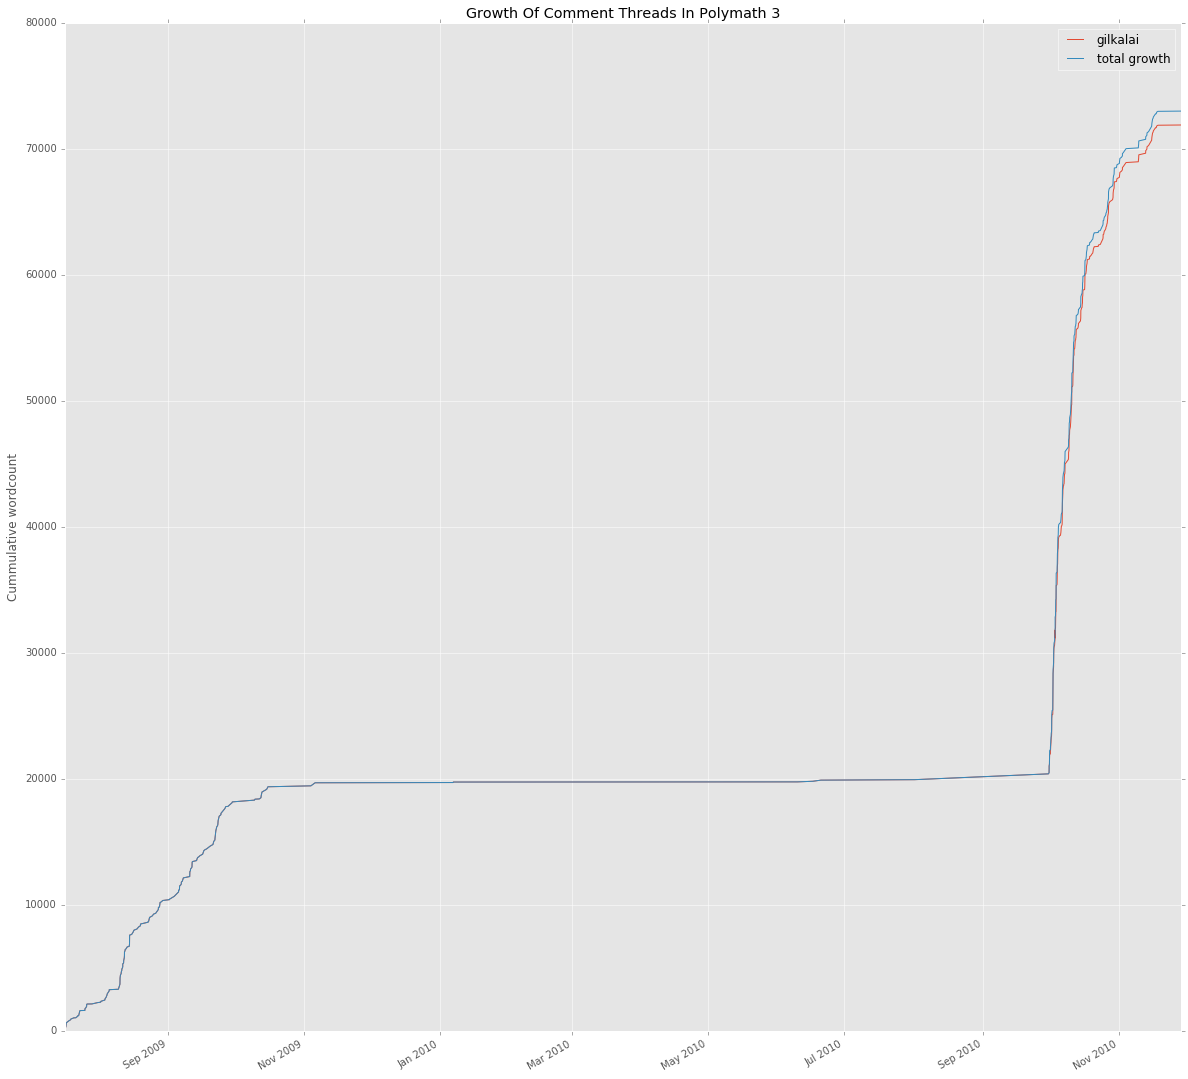

In [12]:
PM3_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('thread', intervals=1, max_span=timedelta(500),
                                                         project="Polymath 3")
PM3_FRAME['mthread (accumulated)'].iloc[-1].plot_growth(drop_last=2,
                                                         project="Polymath 3")

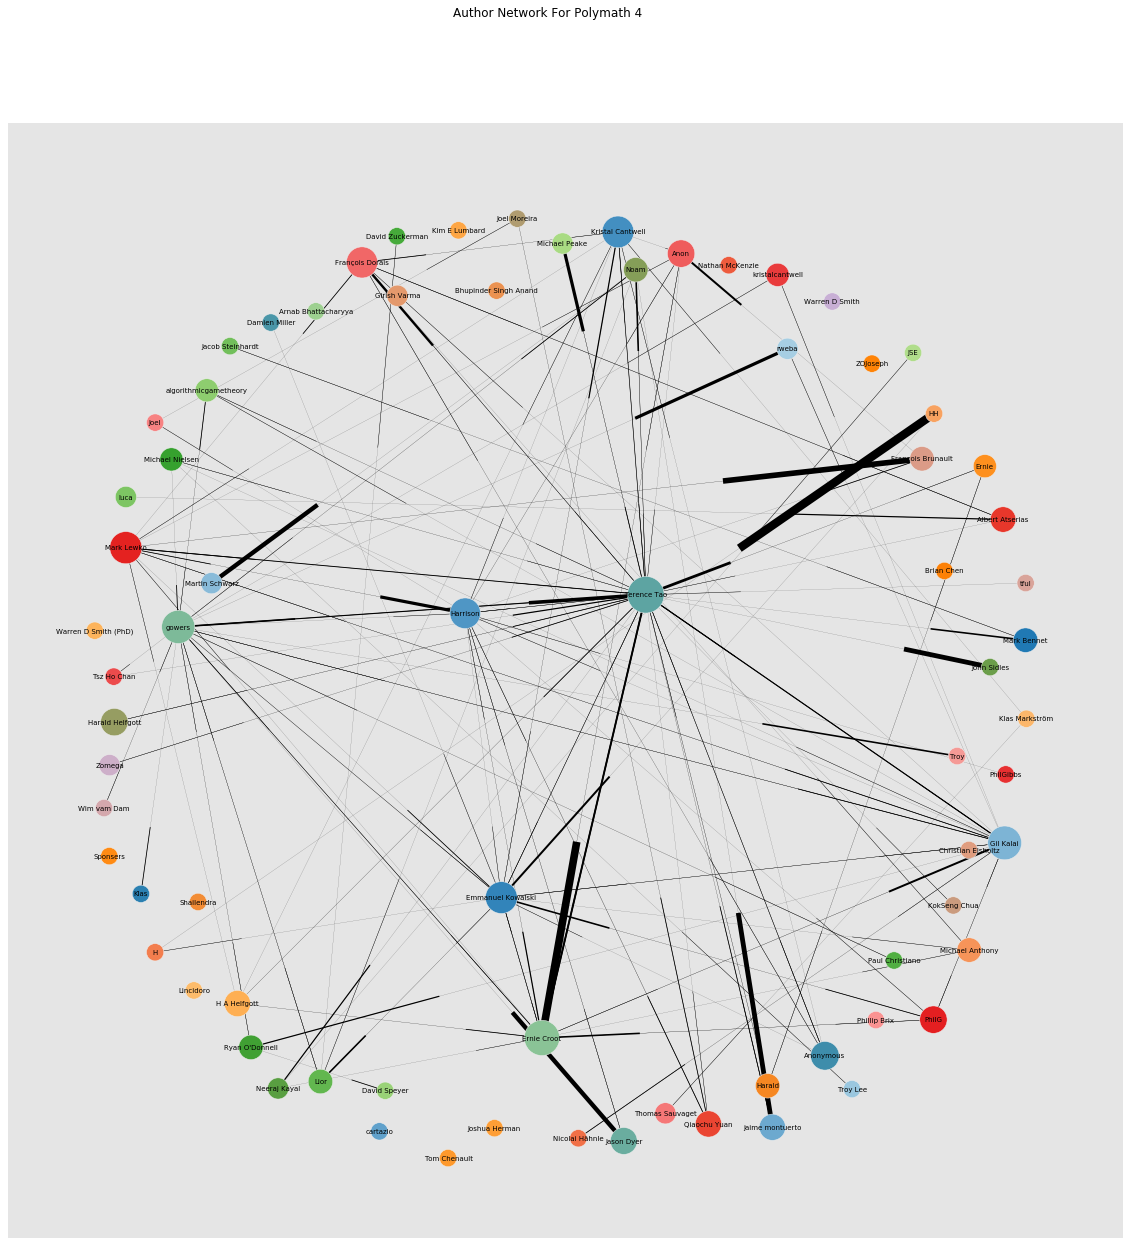

In [13]:
PM4_FRAME['network'].iloc[-1].draw_graph(project="Polymath 4")

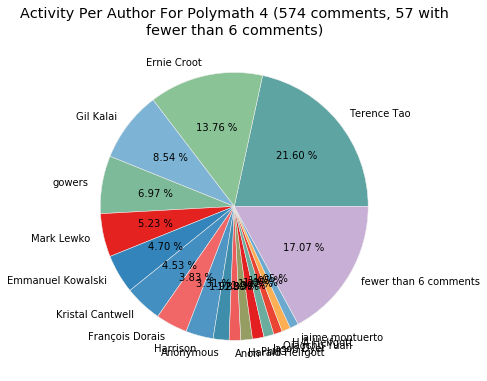

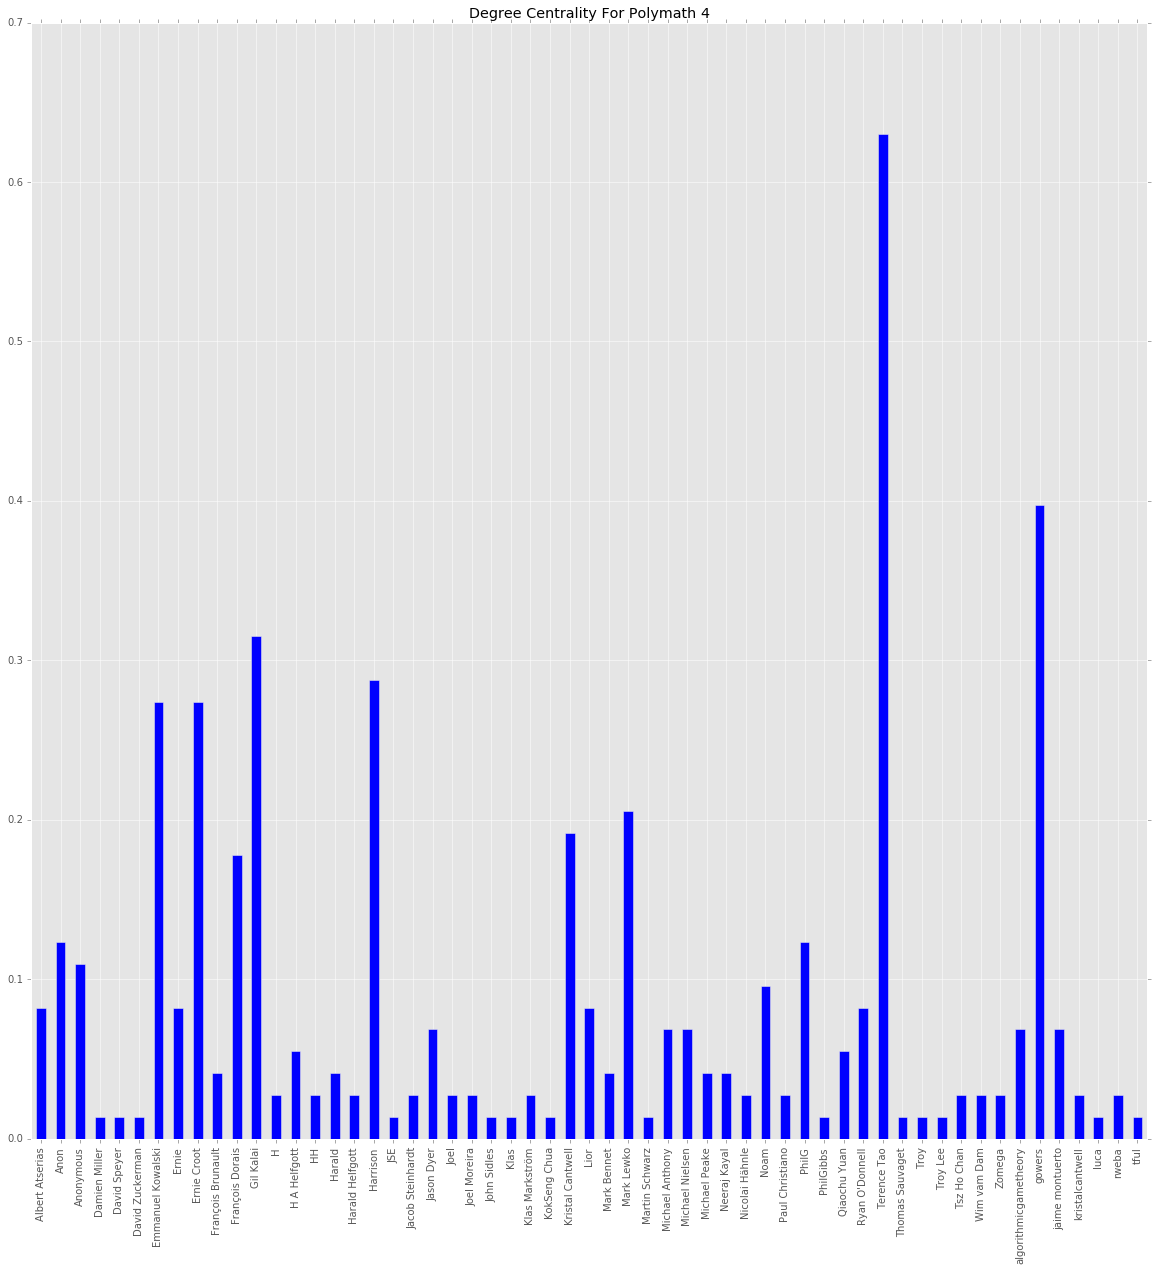

In [14]:
PM4_FRAME['network'].iloc[-1].plot_author_activity_pie(project="Polymath 4")
PM4_FRAME['network'].iloc[-1].plot_degree_centrality(project="Polymath 4")

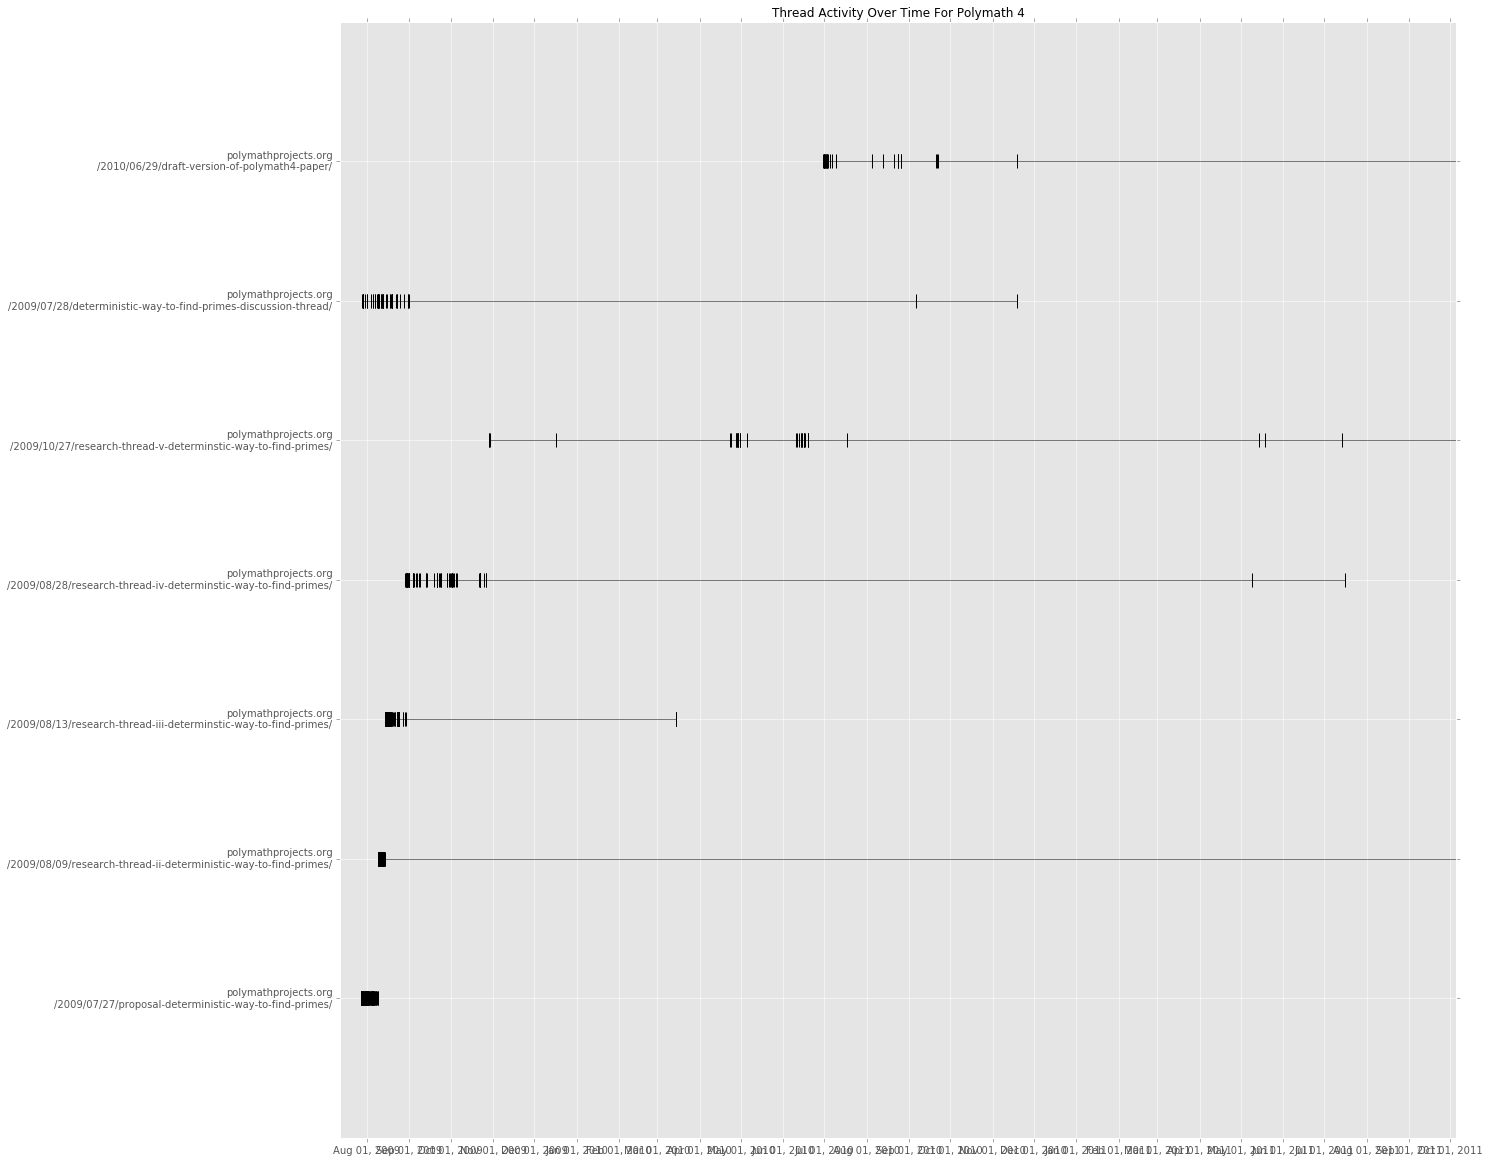

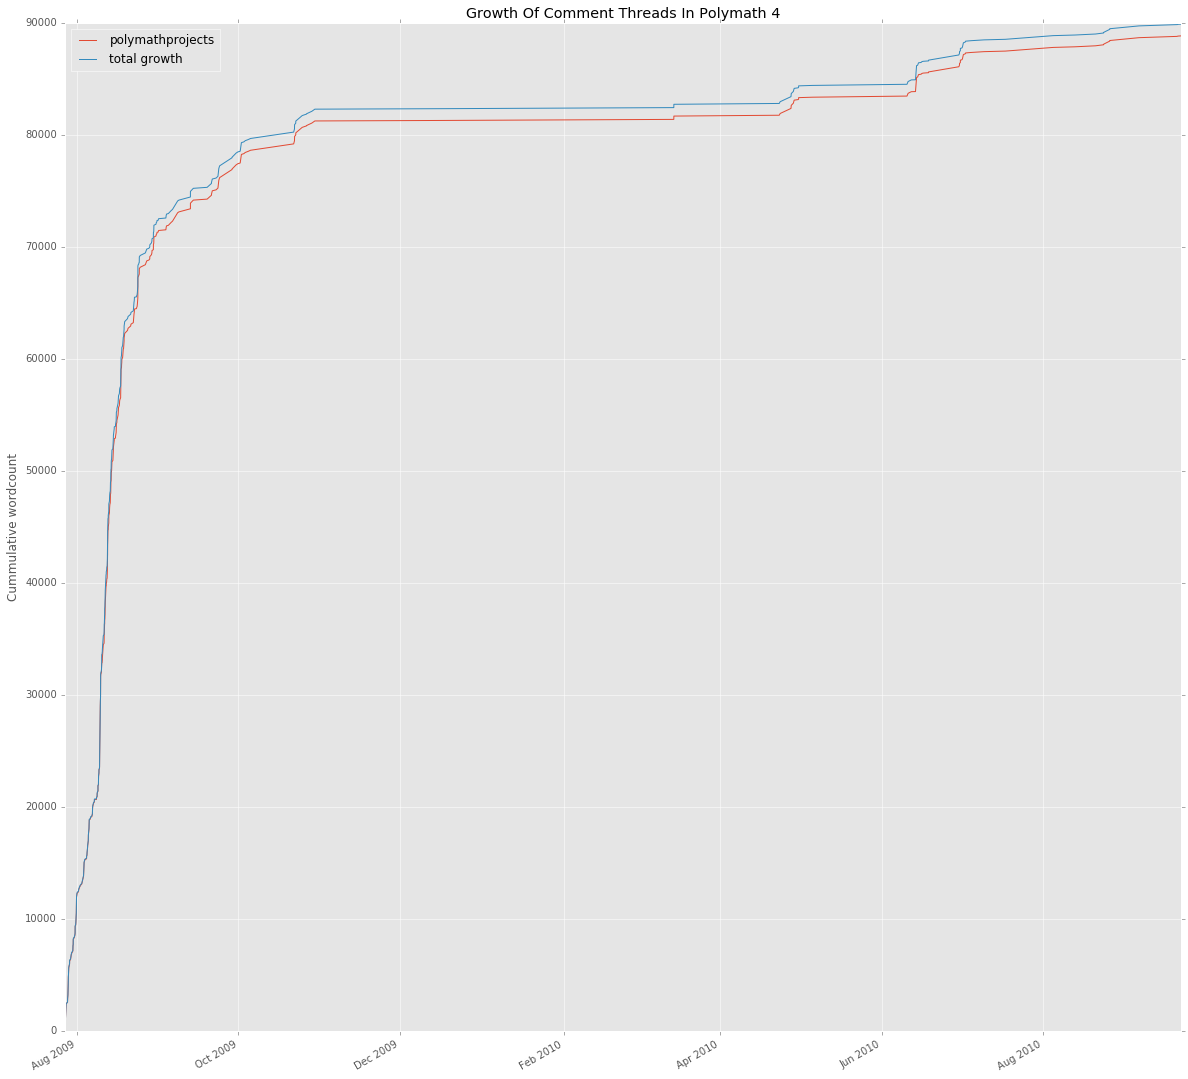

In [15]:
PM4_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('thread', intervals=1, max_span=timedelta(800),
                                                         project="Polymath 4")
PM4_FRAME['mthread (accumulated)'].iloc[-1].plot_growth(drop_last=15,
                                                         project="Polymath 4")

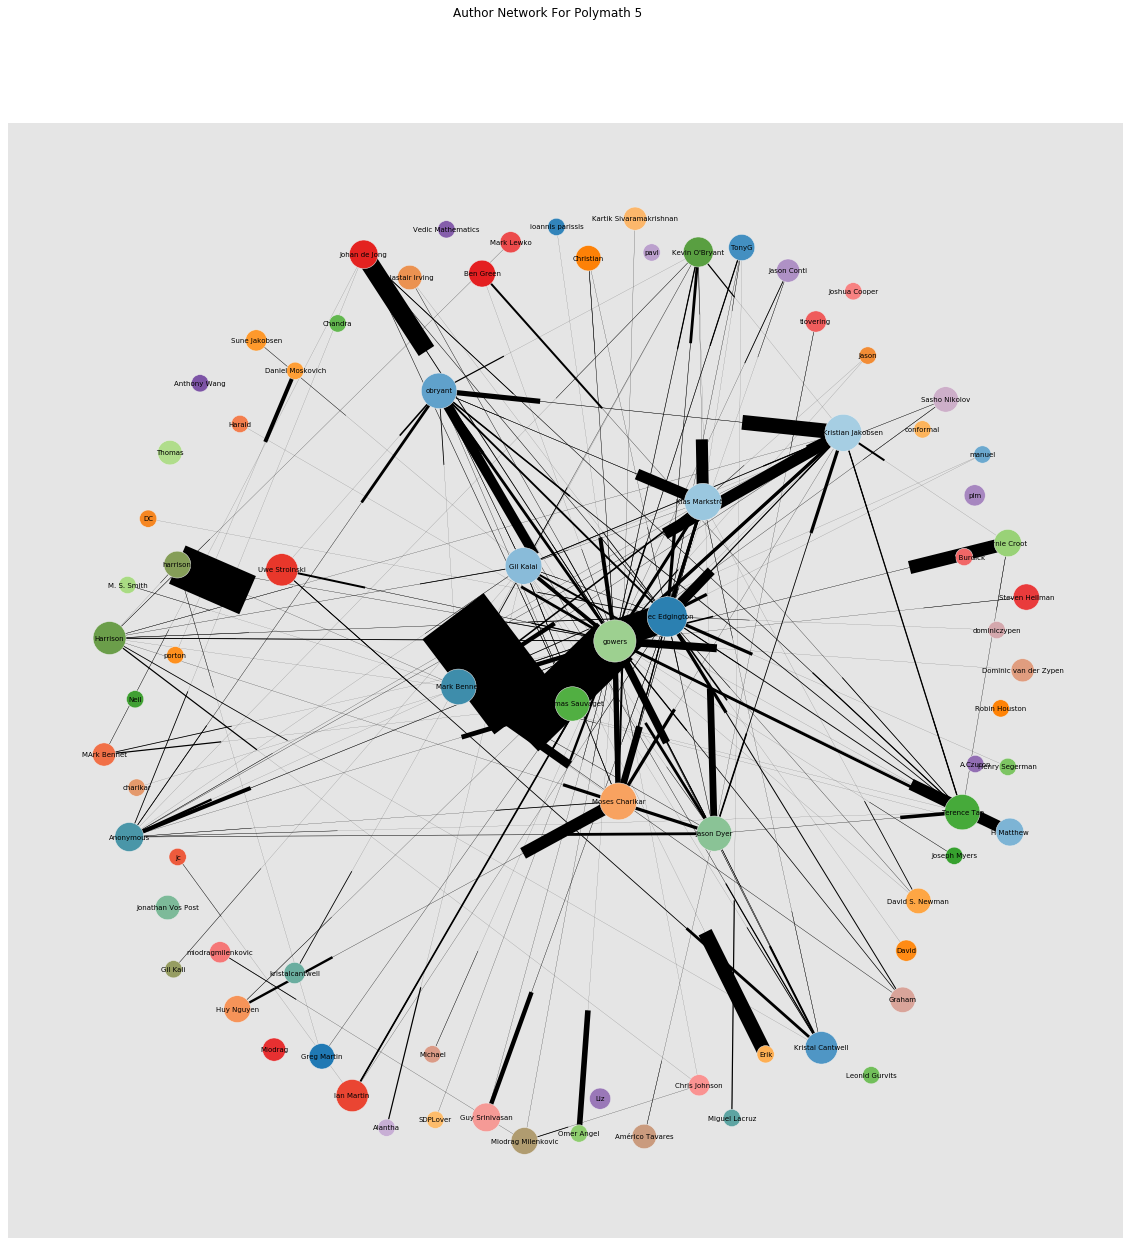

In [16]:
PM5_FRAME['network'].iloc[-1].draw_graph(project="Polymath 5")

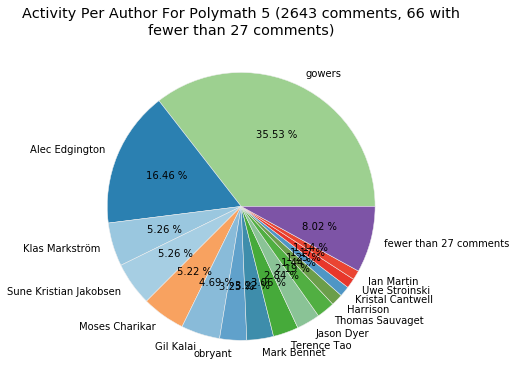

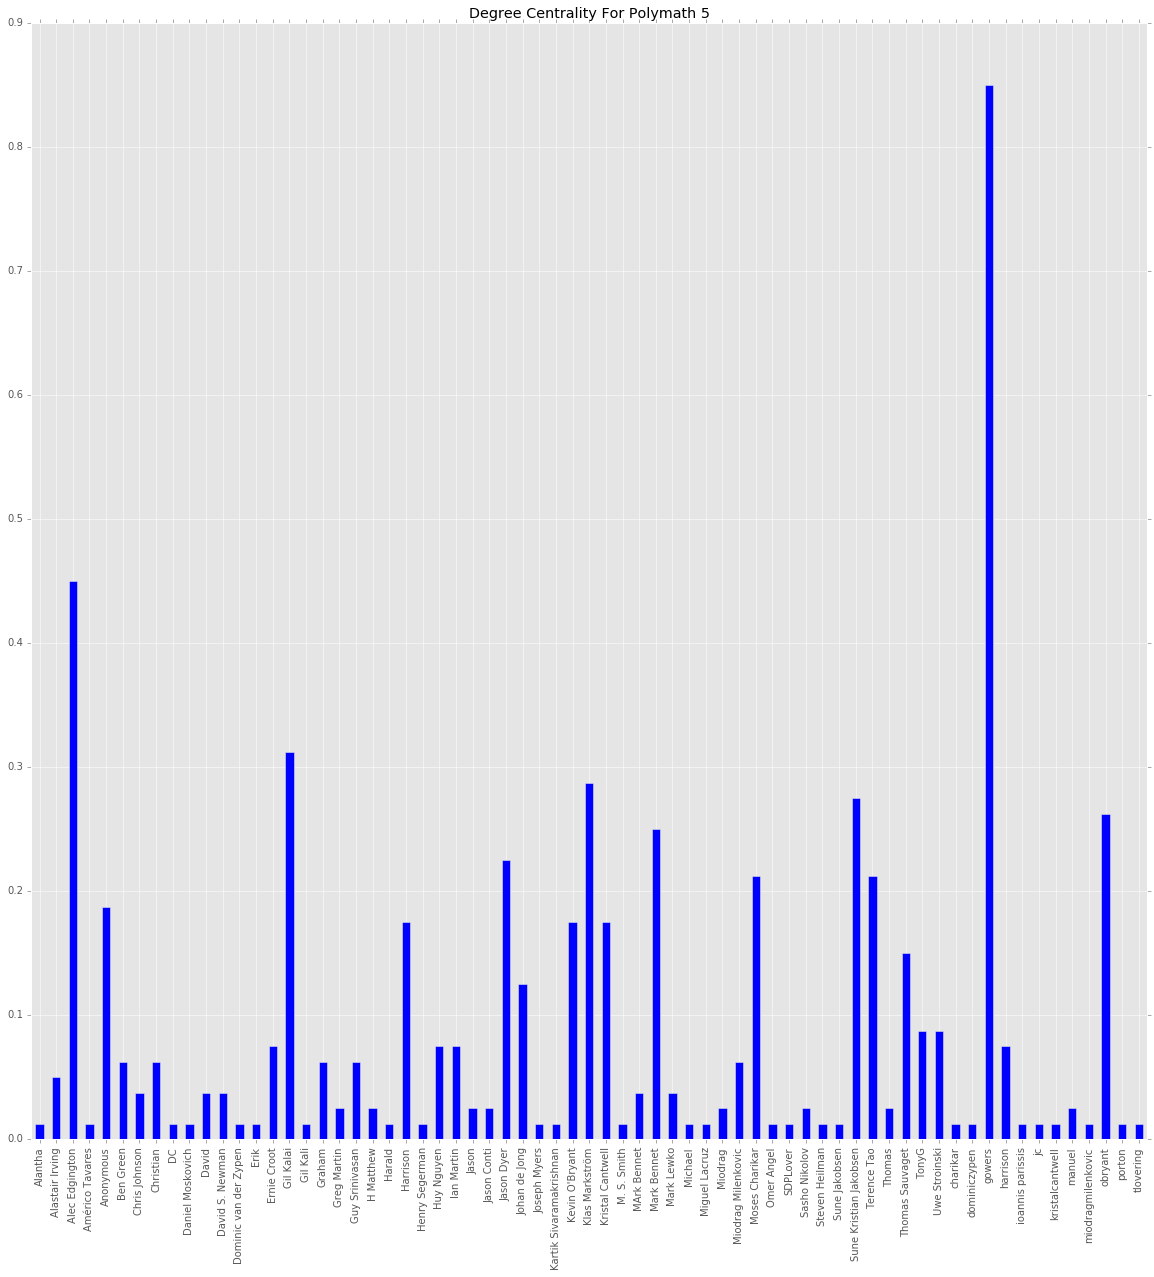

In [17]:
PM5_FRAME['network'].iloc[-1].plot_author_activity_pie(project="Polymath 5")
PM5_FRAME['network'].iloc[-1].plot_degree_centrality(project="Polymath 5")

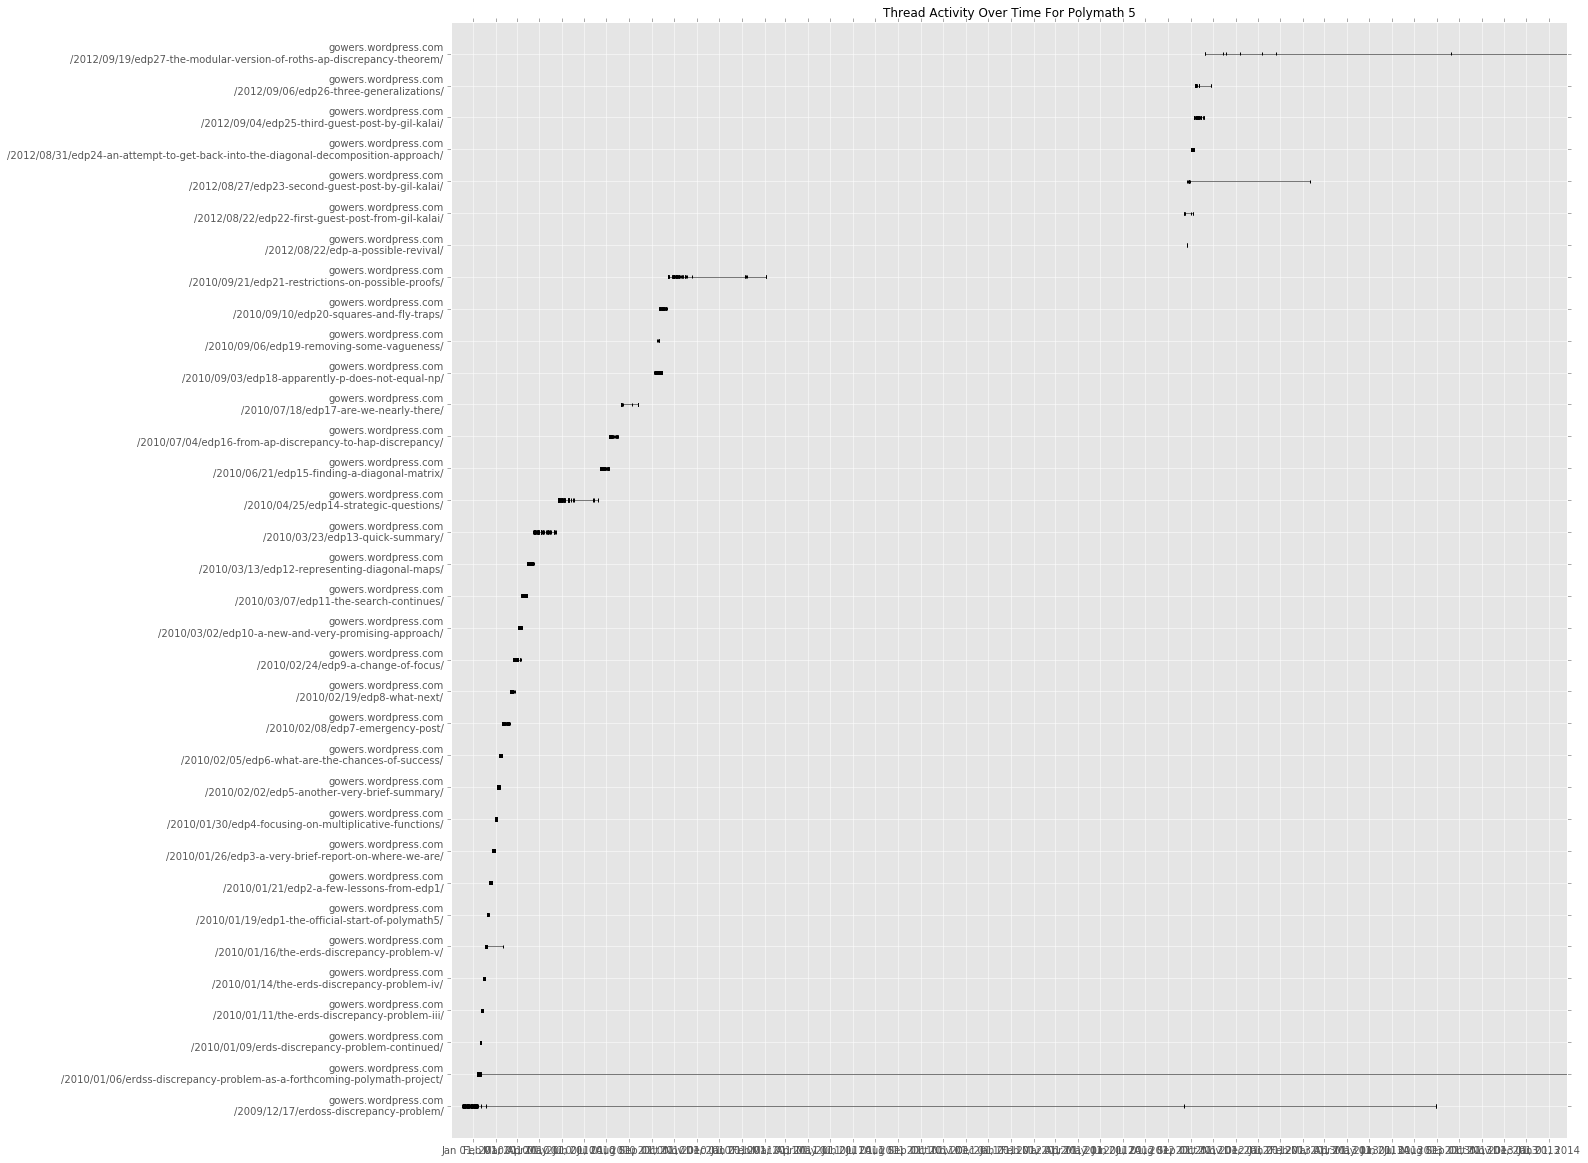

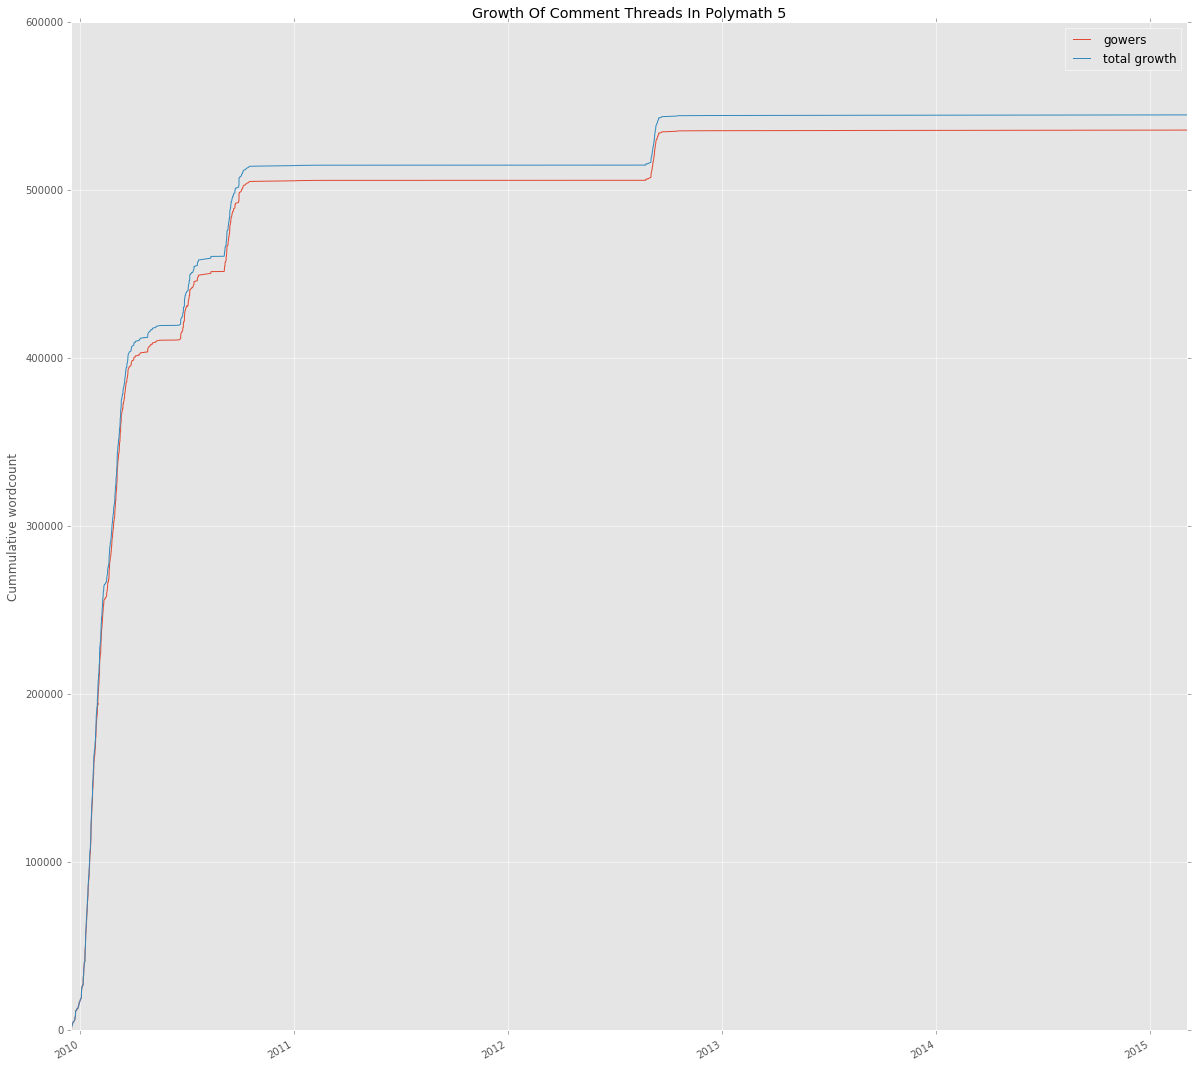

In [18]:
PM5_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('thread', intervals=1, max_span=timedelta(1500),
                                                         project="Polymath 5")
PM5_FRAME['mthread (accumulated)'].iloc[-1].plot_growth(drop_last=0,
                                                         project="Polymath 5")

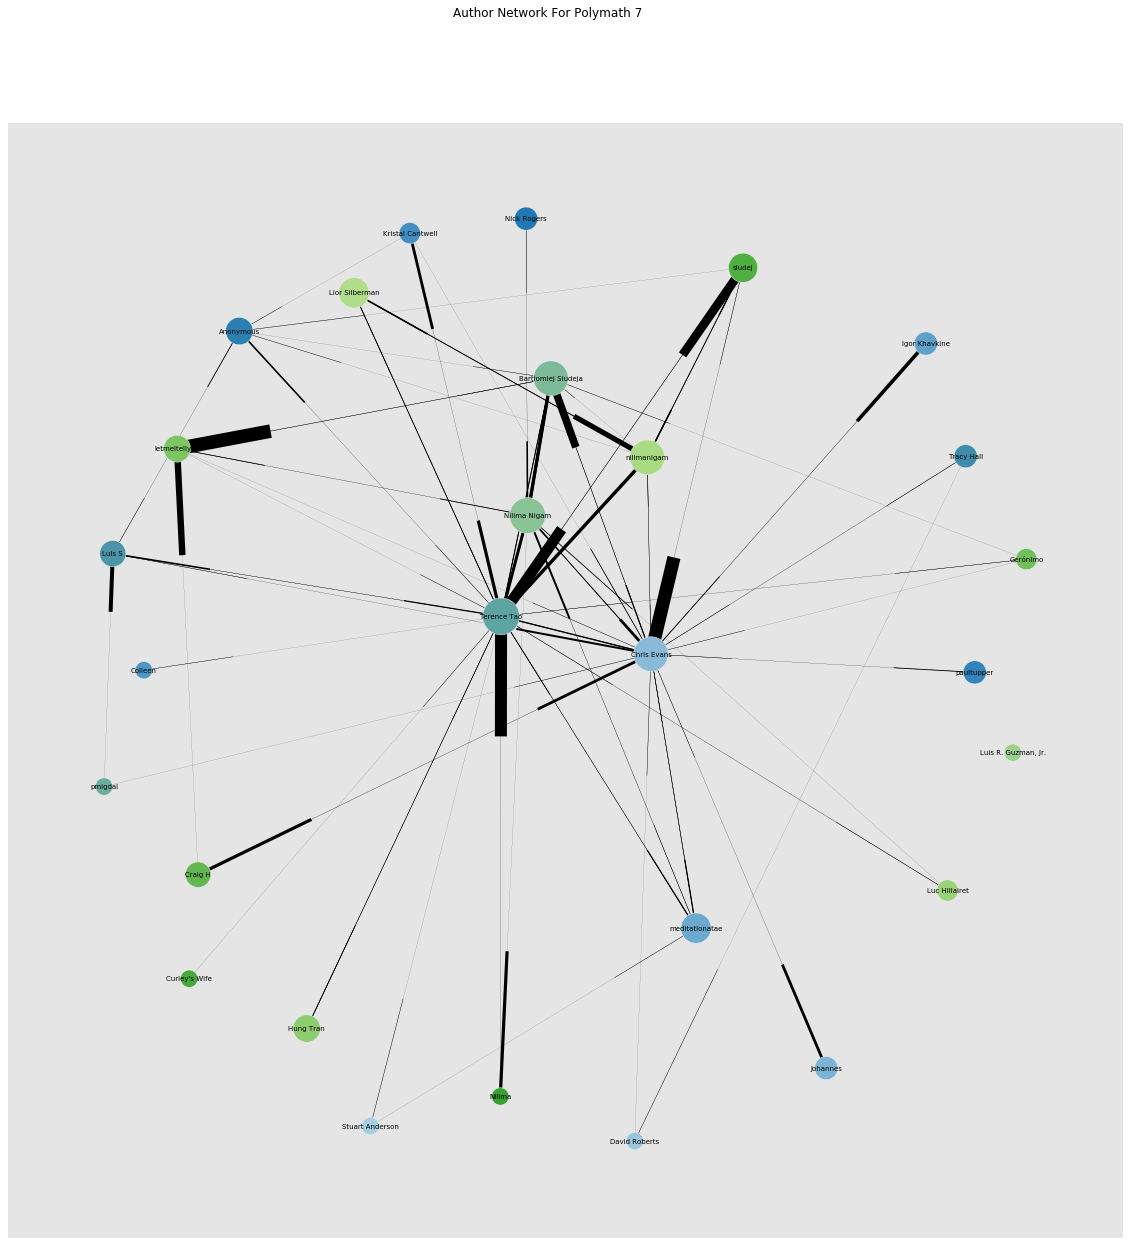

In [19]:
PM7_FRAME['network'].iloc[-1].draw_graph(project="Polymath 7")

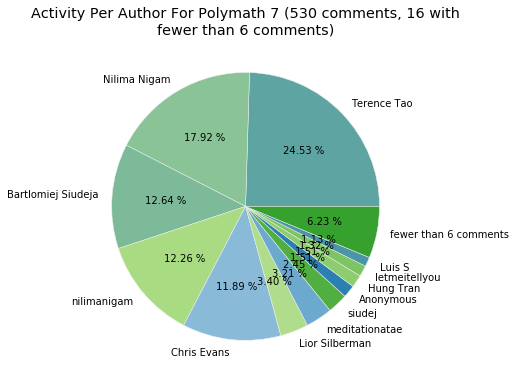

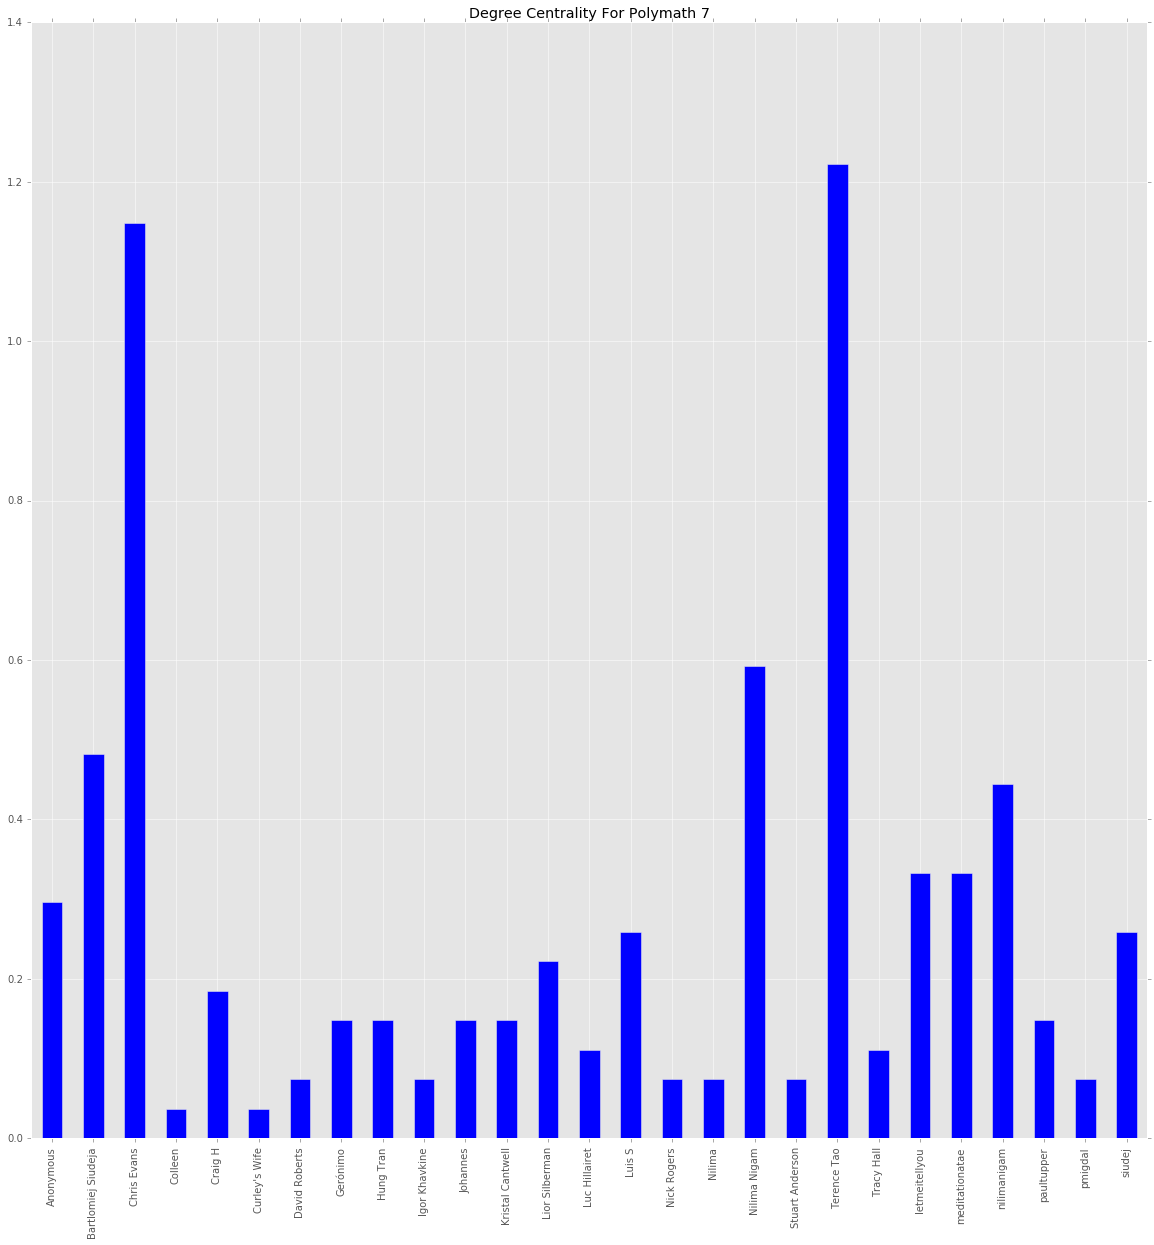

In [20]:
PM7_FRAME['network'].iloc[-1].plot_author_activity_pie(project="Polymath 7")
PM7_FRAME['network'].iloc[-1].plot_degree_centrality(project="Polymath 7")

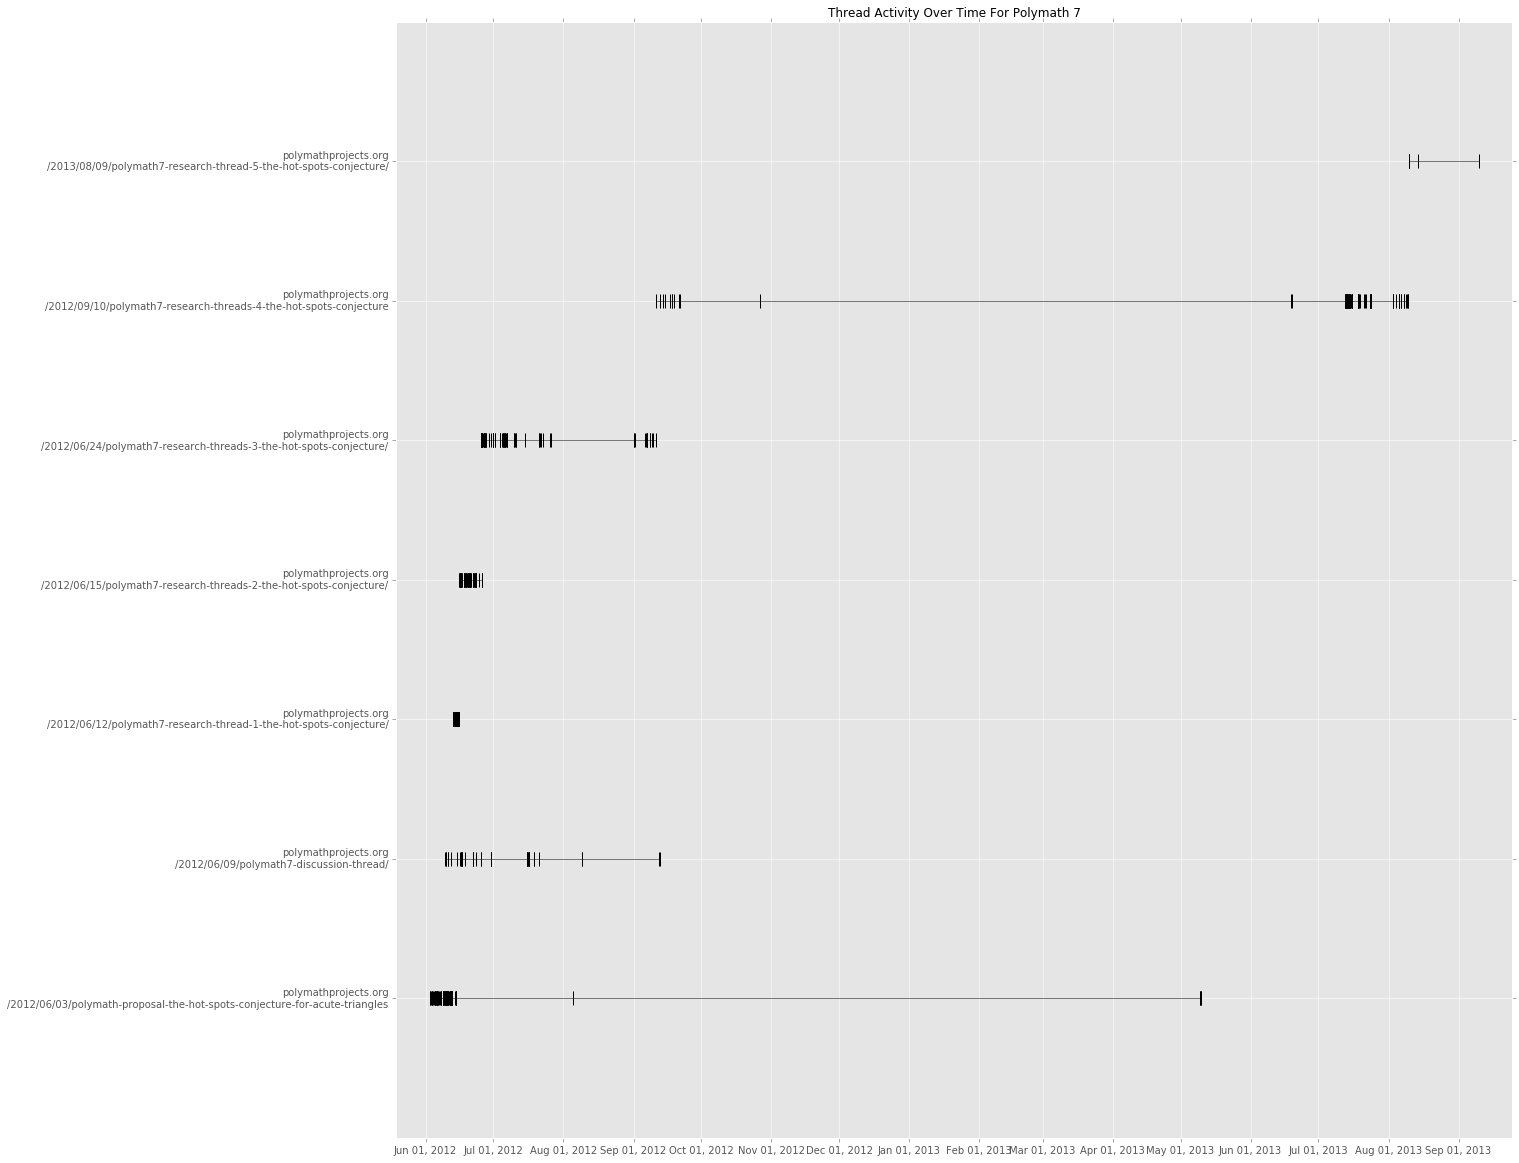

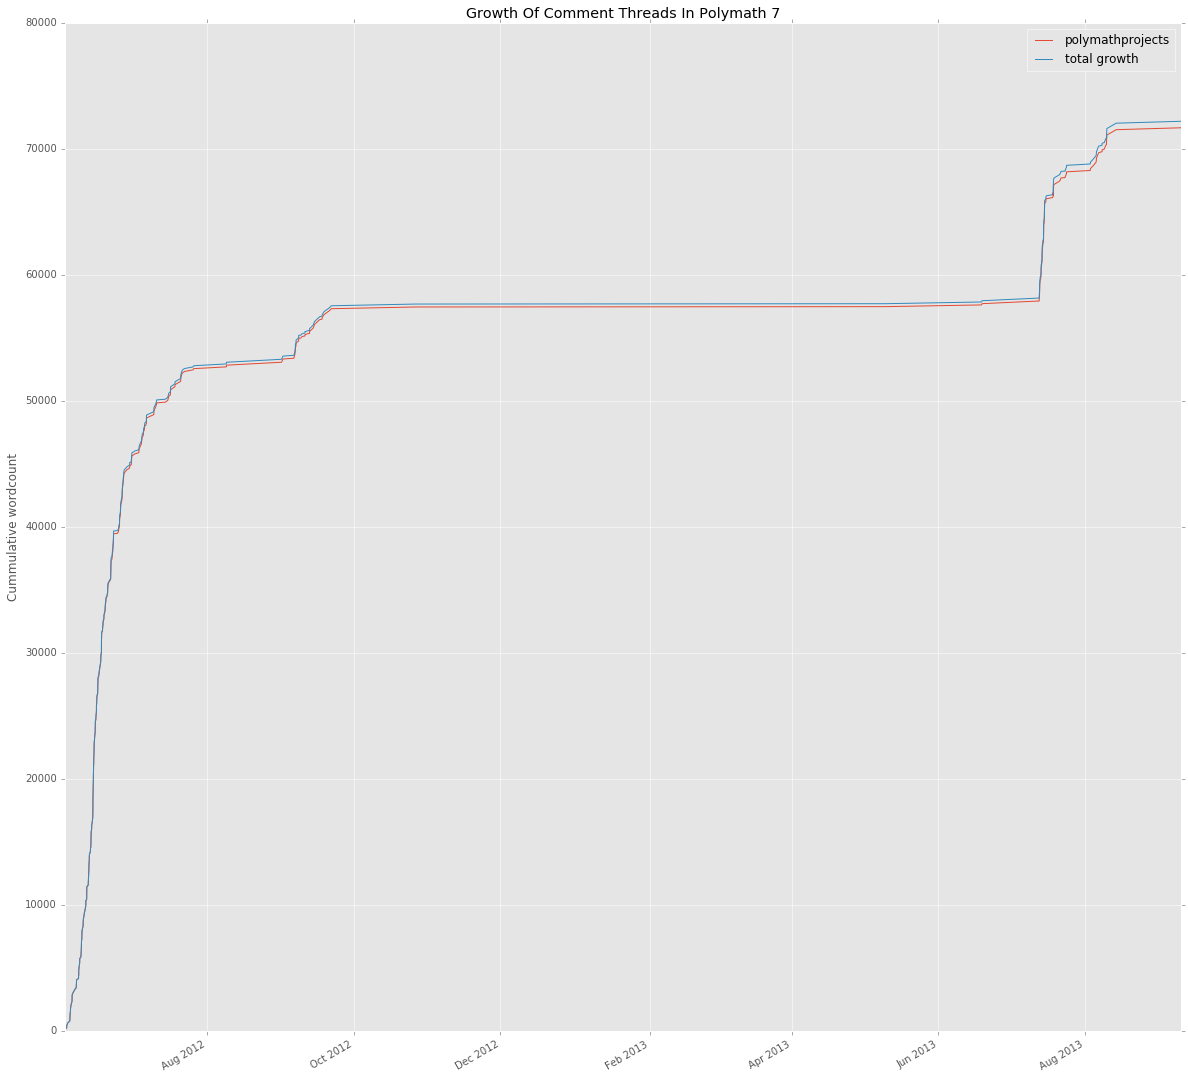

In [21]:
PM7_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('thread', intervals=1, max_span=timedelta(1500),
                                                         project="Polymath 7")
PM7_FRAME['mthread (accumulated)'].iloc[-1].plot_growth(drop_last=0,
                                                         project="Polymath 7")

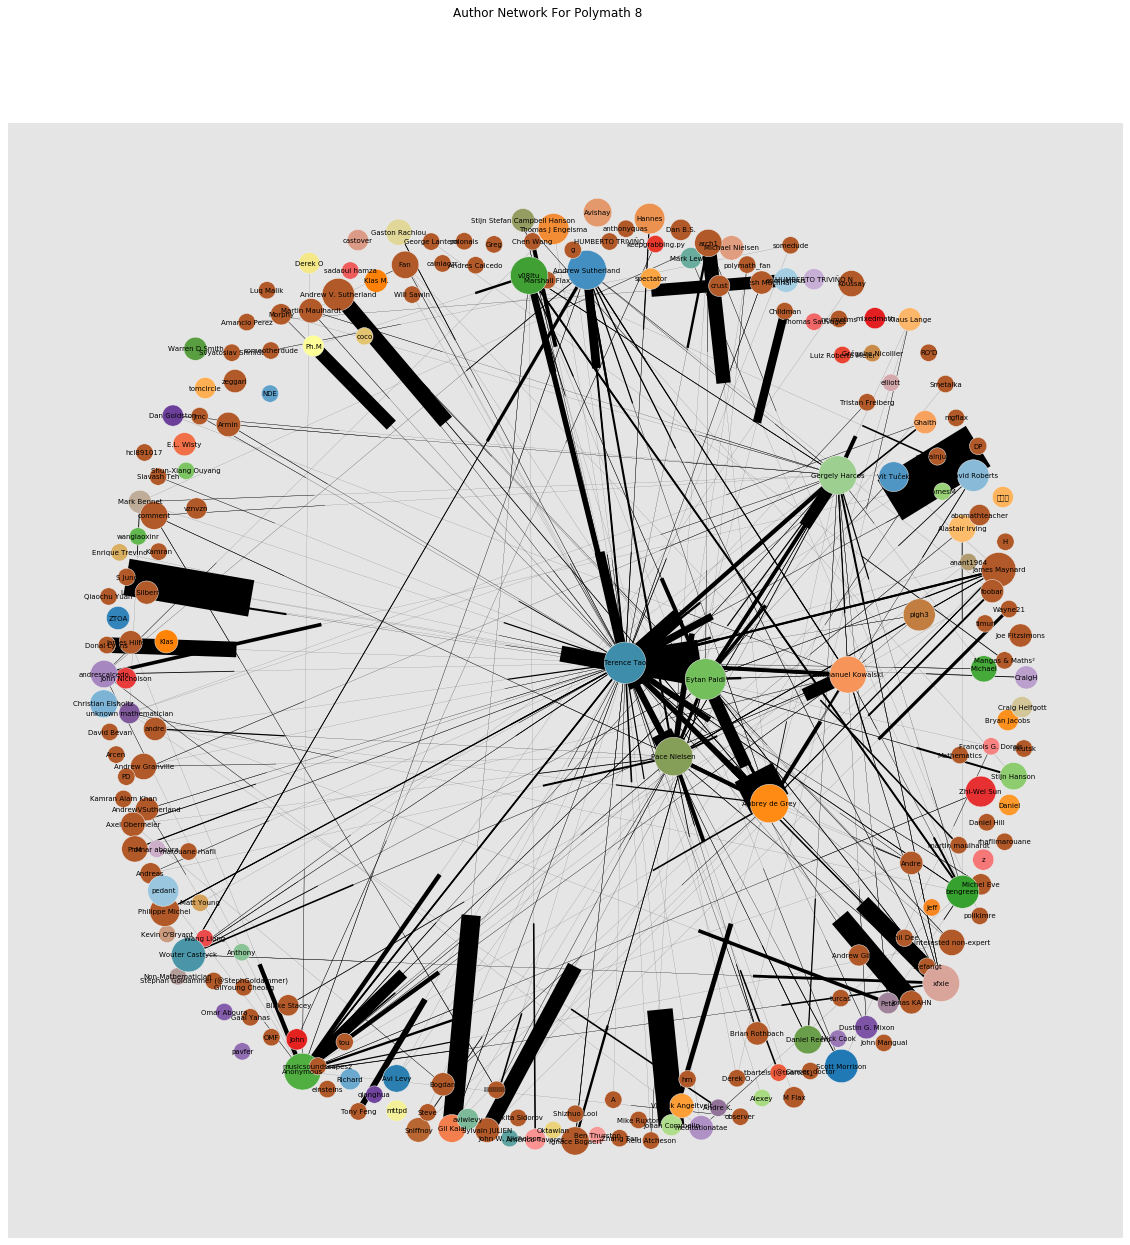

In [22]:
PM8_FRAME['network'].iloc[-1].draw_graph(project="Polymath 8")

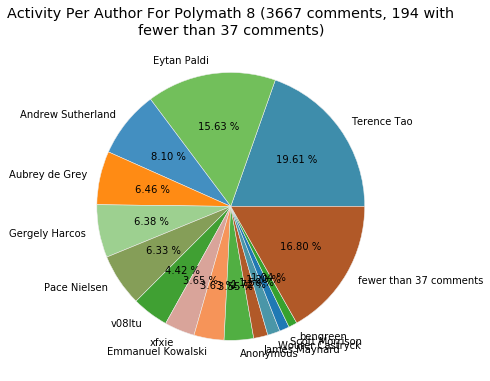

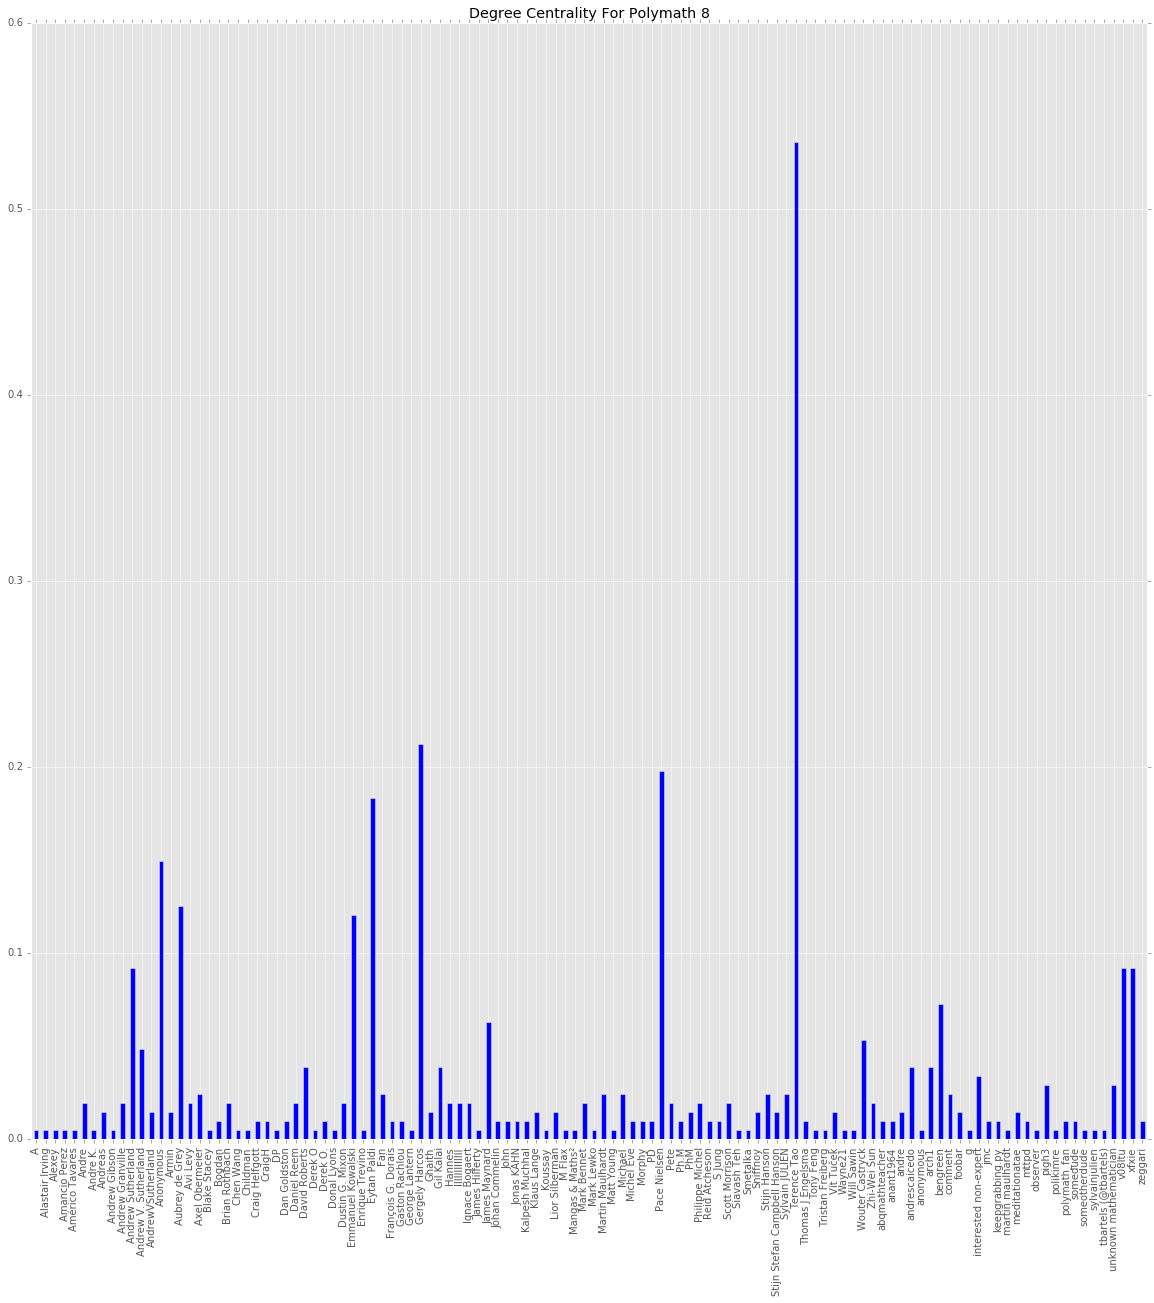

In [23]:
PM8_FRAME['network'].iloc[-1].plot_author_activity_pie(project="Polymath 8")
PM8_FRAME['network'].iloc[-1].plot_degree_centrality(project="Polymath 8")

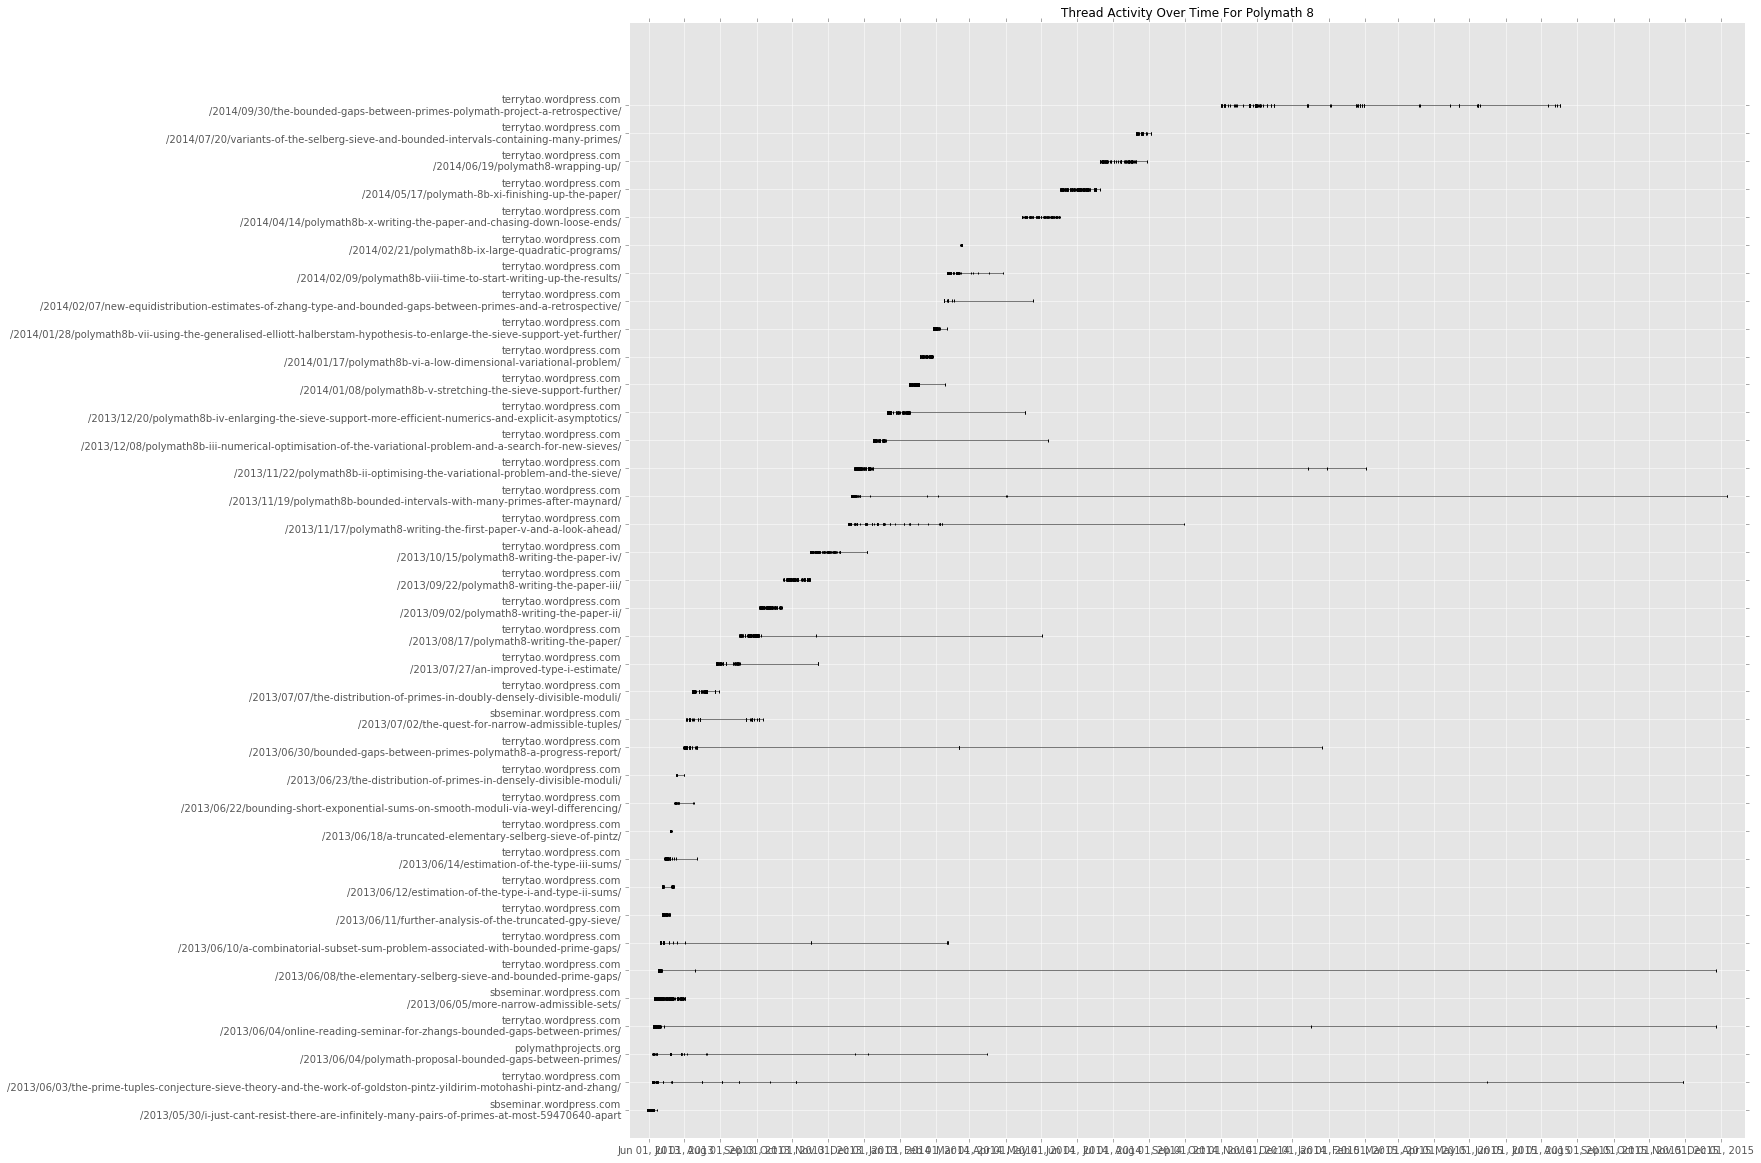

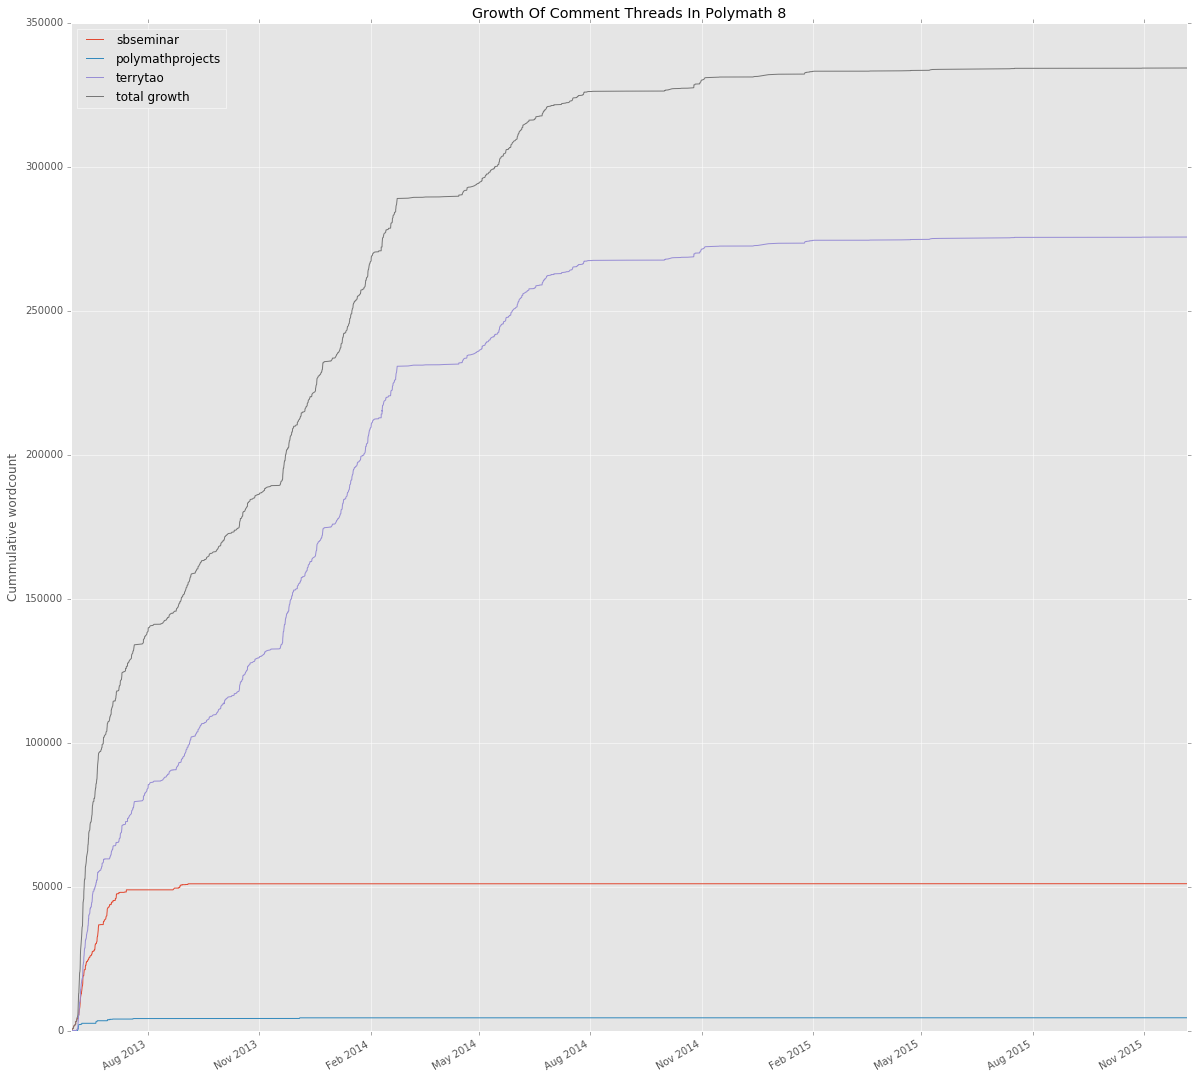

In [24]:
PM8_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('thread', intervals=1, max_span=timedelta(1500),
                                                         project="Polymath 8")
PM8_FRAME['mthread (accumulated)'].iloc[-1].plot_growth(drop_last=0,
                                                         project="Polymath 8")

## Comparing the sizes of the projects

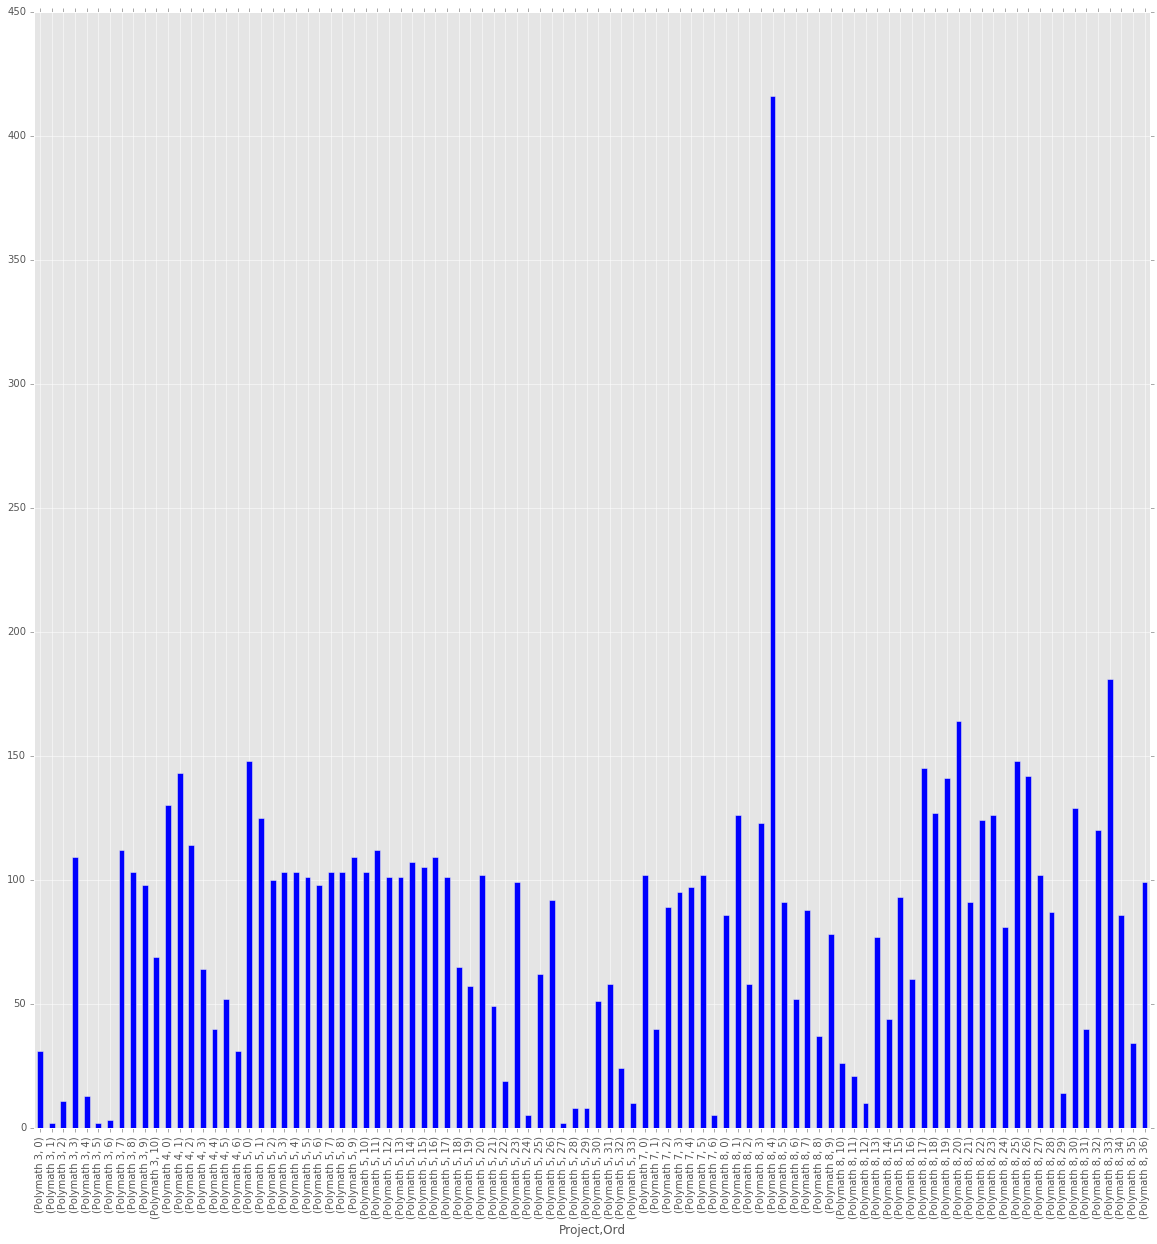

In [29]:
PM_FRAME['number of comments'].plot(kind='bar')

In [30]:
PM_FRAME['number of comments'].describe()

count     96.000000
mean      82.989583
std       55.596572
min        2.000000
25%       43.000000
50%       92.500000
75%      107.500000
max      416.000000
Name: number of comments, dtype: float64

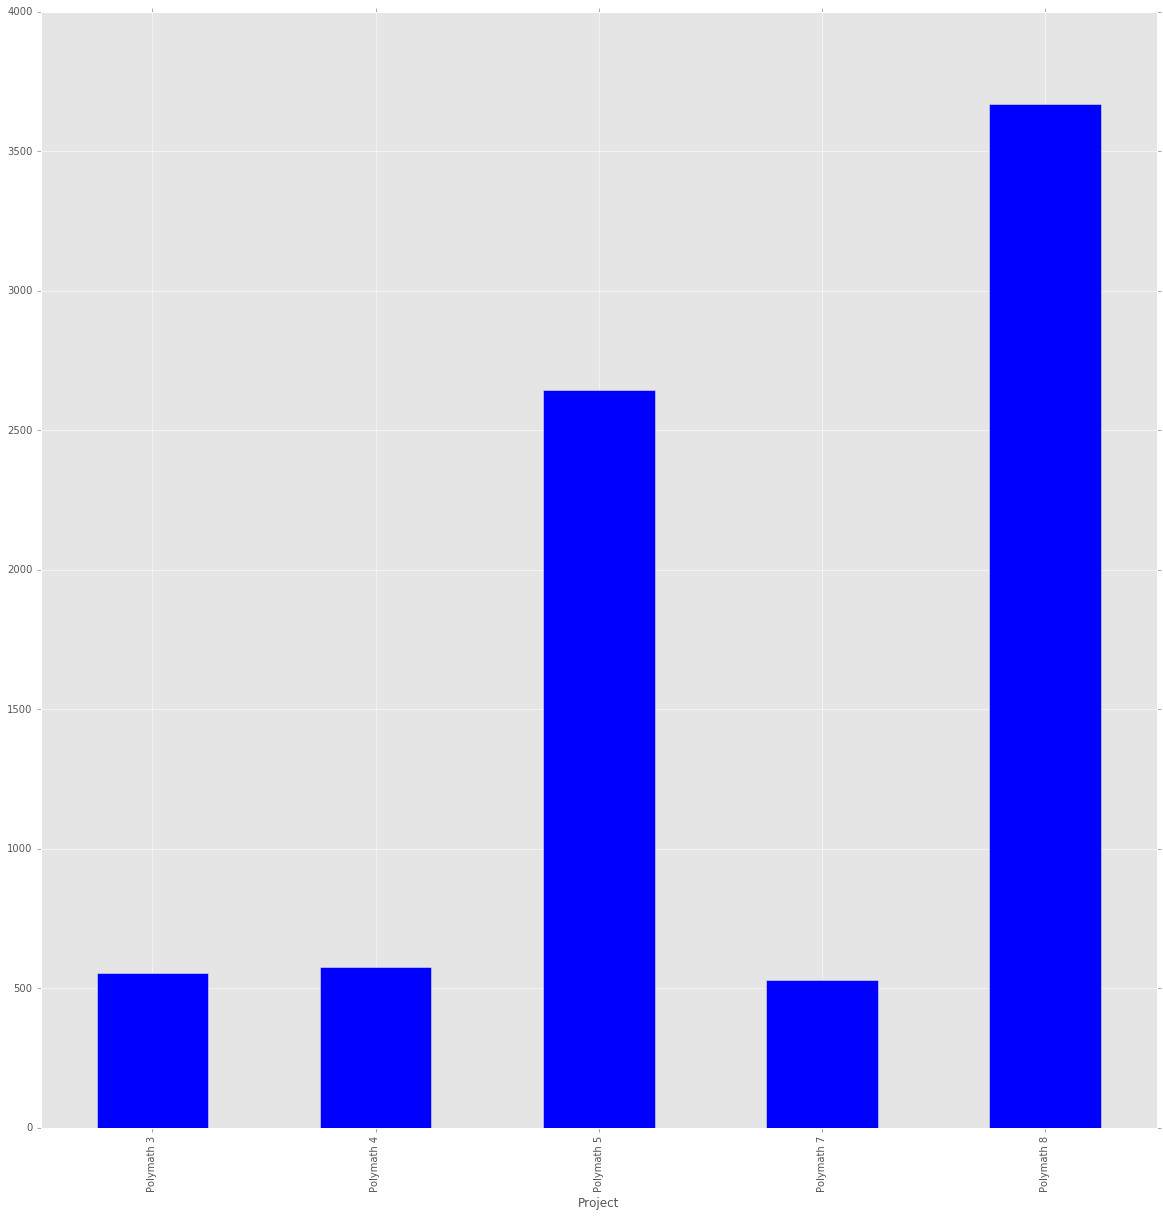

In [39]:
COUNTS = PM_FRAME.groupby(level=0)['number of comments'].sum()
COUNTS.plot(kind="bar")

## Comparing projects and mini-projects